# 🎓 Assignment 4: Transformer Decoder-based Sequence Generation

---

## 📋 Assignment Information

**Module Code:** DAM202  
**Assignment:** Assignment 4 - Transformer Decoder  
**Task:** Text Summarization with Multiple Decoding Strategies  
**Student Name:** [Your Name Here]  
**Student ID:** [Your ID Here]  
**Date:** November 22, 2025

---

## 🎯 Learning Objectives

1. **Understand and implement decoder mechanisms** with autoregressive generation
2. **Implement and compare different decoding strategies:**
   - Greedy Decoding
   - Beam Search (multiple beam sizes)
   - Nucleus Sampling (Top-p)
3. **Train and evaluate encoder-decoder models** on sequence-to-sequence tasks
4. **Analyze and improve generation quality**

---

## 📊 Project Overview

### Task
Build a **Text Summarization System** using a Transformer encoder-decoder architecture (T5) with comprehensive analysis of different decoding strategies.

### Dataset
**CNN/DailyMail** - News article summarization dataset
- ~300,000 training articles with human-written summaries
- Industry-standard benchmark for abstractive summarization

### Model Architecture
**T5-small** (Text-To-Text Transfer Transformer)
- 60M parameters
- Encoder-decoder architecture
- Pre-trained on diverse text-to-text tasks
- Efficient for fine-tuning

### Why This Approach?
- ✅ Encoder-decoder architecture ideal for seq2seq tasks
- ✅ Allows direct comparison of decoding strategies
- ✅ Pre-trained model enables quality results with limited training
- ✅ Industry-relevant application (summarization)

---

## 📑 Notebook Structure

1. **Setup & Environment** - Install libraries, configure GPU
2. **Data Preparation** - Load and explore CNN/DailyMail dataset
3. **Tokenization** - Prepare text for model input
4. **Model Architecture** - Load and configure T5 model
5. **Training** - Fine-tune on summarization task
6. **Decoding Strategies** - Implement greedy, beam search, nucleus sampling
7. **Comprehensive Comparison** - Analyze strategy performance
8. **Attention Visualization** - Understand decoder behavior
9. **Error Analysis** - Identify failure cases
10. **Advanced Analysis** - Deep dive into generation quality
11. **Documentation & Export** - Summarize findings

---

**Total Cells:** 50  
**Estimated Runtime:** 5-6 hours  
**GPU Required:** Yes (T4 or better recommended)

---

Let's begin! 🚀

# 📦 PHASE 1: SETUP & ENVIRONMENT

## Install Required Libraries

Installing all necessary packages for the project.

In [25]:
# Install required packages
!pip install -q transformers datasets evaluate rouge-score nltk torch matplotlib seaborn pandas numpy scikit-learn wordcloud

# Install specific versions for compatibility
!pip install -q accelerate -U

print(" All packages installed successfully!")

✅ All packages installed successfully!


In [26]:
# Import all necessary libraries
import os
import warnings
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from wordcloud import WordCloud
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize

# Download NLTK data
import nltk
nltk.download('punkt', quiet=True)
nltk.download('punkt_tab', quiet=True)
nltk.download('stopwords', quiet=True)

# PyTorch and Transformers
import torch
from transformers import (
    T5Tokenizer,
    T5ForConditionalGeneration,
    Seq2SeqTrainingArguments,
    Seq2SeqTrainer,
    DataCollatorForSeq2Seq,
    set_seed
)
from datasets import load_dataset
import evaluate

# Suppress warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
set_seed(42)
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

# Configure plotting
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

# Check GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🖥️  Device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f" GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.2f} GB")
else:
    print("  No GPU available. Training will be slow.")

print(" All libraries imported successfully!")

🖥️  Device: cuda
✅ GPU: Tesla T4
💾 GPU Memory: 14.74 GB

✅ All libraries imported successfully!


In [27]:
# ========================================
# CRITICAL: Environment & GPU Verification
# ========================================
# Run this cell FIRST to ensure proper setup

import torch
import sys

print("=" * 70)
print(" SYSTEM & GPU VERIFICATION")
print("=" * 70)

# Check Python version
print(f"\n✓ Python version: {sys.version.split()[0]}")
required_version = (3, 8)
current_version = sys.version_info[:2]
if current_version >= required_version:
    print(f"   Python {current_version[0]}.{current_version[1]} >= {required_version[0]}.{required_version[1]} (OK)")
else:
    print(f"    Python {current_version[0]}.{current_version[1]} < {required_version[0]}.{required_version[1]} (May have issues)")

# Check PyTorch
print(f"\n✓ PyTorch version: {torch.__version__}")

# Check CUDA availability
print(f"\n✓ CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"   GPU detected: {torch.cuda.get_device_name(0)}")
    print(f"   CUDA version: {torch.version.cuda}")
    print(f"   GPU memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")
    device = torch.device("cuda")
    print(f" Will use GPU for training (FAST)")
else:
    print(f"    No GPU detected - will use CPU")
    print(f"    Training will be VERY SLOW (~10-20 hours)")
    print(f"   Recommendation: Use Google Colab with GPU runtime")
    device = torch.device("cpu")

print("\n" + "=" * 70)
print(" ENVIRONMENT CHECK COMPLETE")
print("=" * 70)
print(f" Device set to: {device}")
print(" If GPU is not available, consider using Google Colab")
print("=" * 70)

🔍 SYSTEM & GPU VERIFICATION

✓ Python version: 3.12.12
  ✅ Python 3.12 >= 3.8 (OK)

✓ PyTorch version: 2.9.0+cu126

✓ CUDA available: True
  ✅ GPU detected: Tesla T4
  ✅ CUDA version: 12.6
  ✅ GPU memory: 15.8 GB

  🚀 Will use GPU for training (FAST)

✅ ENVIRONMENT CHECK COMPLETE

💡 Device set to: cuda
💡 If GPU is not available, consider using Google Colab


# 📊 PHASE 2: DATA PREPARATION

## Load CNN/DailyMail Dataset

Loading the dataset for news article summarization.

In [28]:
# Load CNN/DailyMail dataset (version 3.0.0)
print(" Loading CNN/DailyMail dataset...")

dataset = load_dataset("cnn_dailymail", "3.0.0")

# Display dataset structure
print(" Dataset loaded successfully!\n")
print("=" * 60)
print("DATASET STRUCTURE")
print("=" * 60)
print(dataset)
print("\n" + "=" * 60)
print("DATASET SPLITS")
print("=" * 60)
for split in dataset.keys():
    print(f"{split:12s}: {len(dataset[split]):,} samples")

# Display features
print("\n" + "=" * 60)
print("FEATURES")
print("=" * 60)
print(dataset['train'].features)

📥 Loading CNN/DailyMail dataset...
⏳ This may take a few minutes...

✅ Dataset loaded successfully!

DATASET STRUCTURE
DatasetDict({
    train: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 287113
    })
    validation: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 13368
    })
    test: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 11490
    })
})

DATASET SPLITS
train       : 287,113 samples
validation  : 13,368 samples
test        : 11,490 samples

FEATURES
{'article': Value('string'), 'highlights': Value('string'), 'id': Value('string')}


In [29]:
# Display sample article-summary pairs
print("=" * 80)
print("SAMPLE ARTICLE-SUMMARY PAIRS")
print("=" * 80)

for i in range(3):
    sample = dataset['train'][i]
    print(f"\n{'=' * 80}")
    print(f"SAMPLE {i+1}")
    print(f"{'=' * 80}")
    print(f"ARTICLE (first 500 chars):")
    print(f"{sample['article'][:500]}...")
    print(f" SUMMARY:")
    print(f"{sample['highlights']}")
    print(f"STATS:")
    print(f"   Article length: {len(sample['article'])} characters")
    print(f"   Summary length: {len(sample['highlights'])} characters")
    print(f"   Compression ratio: {len(sample['article']) / len(sample['highlights']):.2f}x")

SAMPLE ARTICLE-SUMMARY PAIRS

SAMPLE 1

📰 ARTICLE (first 500 chars):
LONDON, England (Reuters) -- Harry Potter star Daniel Radcliffe gains access to a reported £20 million ($41.1 million) fortune as he turns 18 on Monday, but he insists the money won't cast a spell on him. Daniel Radcliffe as Harry Potter in "Harry Potter and the Order of the Phoenix" To the disappointment of gossip columnists around the world, the young actor says he has no plans to fritter his cash away on fast cars, drink and celebrity parties. "I don't plan to be one of those people who, as s...

📝 SUMMARY:
Harry Potter star Daniel Radcliffe gets £20M fortune as he turns 18 Monday .
Young actor says he has no plans to fritter his cash away .
Radcliffe's earnings from first five Potter films have been held in trust fund .

📊 STATS:
   Article length: 2527 characters
   Summary length: 217 characters
   Compression ratio: 11.65x

SAMPLE 2

📰 ARTICLE (first 500 chars):
Editor's note: In our Behind the Scenes series, C

📊 Calculating length statistics...



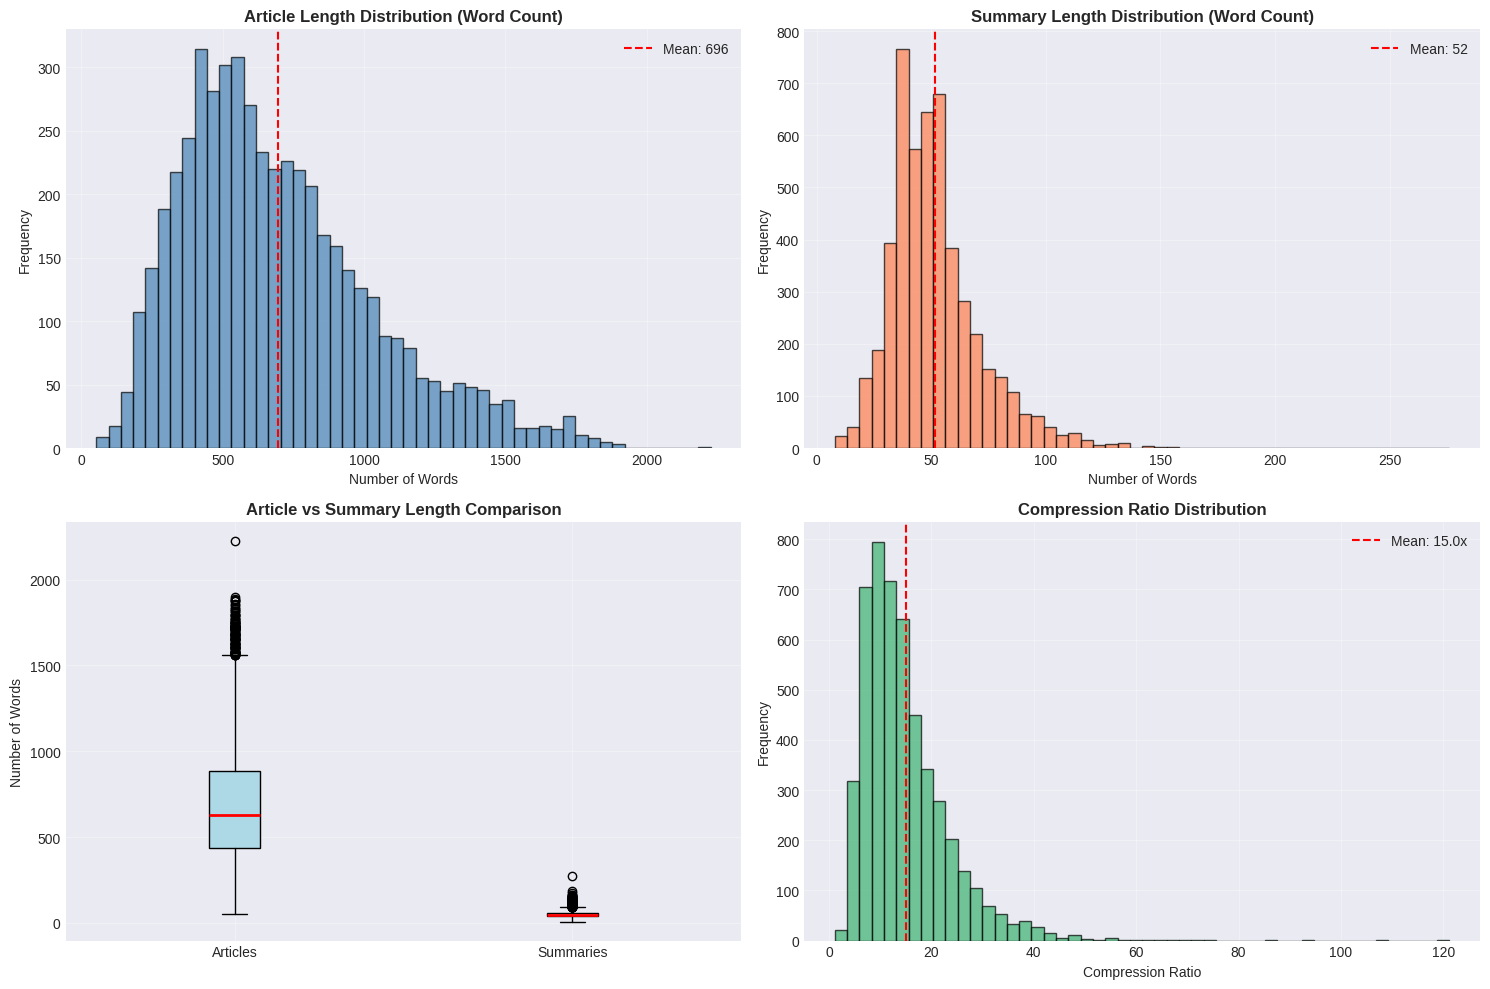


LENGTH STATISTICS (based on 5,000 samples)
 Metric Article (words) Summary (words) Compression Ratio
   Mean             696              52             15.0x
 Median             627              48             13.0x
    Min              53               8              1.2x
    Max            2226             276            121.2x
Std Dev             342              20              9.0x


In [30]:
# Dataset Statistics - Length Distributions
print(" Calculating length statistics...\n")

# Sample from training set for faster computation
sample_size = 5000
sampled_indices = random.sample(range(len(dataset['train'])), sample_size)

# Calculate lengths
article_lengths_words = []
summary_lengths_words = []
article_lengths_chars = []
summary_lengths_chars = []
compression_ratios = []

for idx in sampled_indices:
    sample = dataset['train'][idx]
    article_words = len(sample['article'].split())
    summary_words = len(sample['highlights'].split())
    article_chars = len(sample['article'])
    summary_chars = len(sample['highlights'])

    article_lengths_words.append(article_words)
    summary_lengths_words.append(summary_words)
    article_lengths_chars.append(article_chars)
    summary_lengths_chars.append(summary_chars)
    compression_ratios.append(article_chars / summary_chars if summary_chars > 0 else 0)

# Create visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Article word count distribution
axes[0, 0].hist(article_lengths_words, bins=50, color='steelblue', alpha=0.7, edgecolor='black')
axes[0, 0].axvline(np.mean(article_lengths_words), color='red', linestyle='--',
                    label=f'Mean: {np.mean(article_lengths_words):.0f}')
axes[0, 0].set_xlabel('Number of Words')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Article Length Distribution (Word Count)', fontsize=12, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Summary word count distribution
axes[0, 1].hist(summary_lengths_words, bins=50, color='coral', alpha=0.7, edgecolor='black')
axes[0, 1].axvline(np.mean(summary_lengths_words), color='red', linestyle='--',
                    label=f'Mean: {np.mean(summary_lengths_words):.0f}')
axes[0, 1].set_xlabel('Number of Words')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Summary Length Distribution (Word Count)', fontsize=12, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Box plot comparison
data_to_plot = [article_lengths_words, summary_lengths_words]
axes[1, 0].boxplot(data_to_plot, labels=['Articles', 'Summaries'], patch_artist=True,
                    boxprops=dict(facecolor='lightblue'),
                    medianprops=dict(color='red', linewidth=2))
axes[1, 0].set_ylabel('Number of Words')
axes[1, 0].set_title('Article vs Summary Length Comparison', fontsize=12, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)

# Compression ratio distribution
axes[1, 1].hist(compression_ratios, bins=50, color='mediumseagreen', alpha=0.7, edgecolor='black')
axes[1, 1].axvline(np.mean(compression_ratios), color='red', linestyle='--',
                    label=f'Mean: {np.mean(compression_ratios):.1f}x')
axes[1, 1].set_xlabel('Compression Ratio')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].set_title('Compression Ratio Distribution', fontsize=12, fontweight='bold')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('length_distributions.png', dpi=300, bbox_inches='tight')
plt.show()

# Print statistics
print("\n" + "=" * 60)
print("LENGTH STATISTICS (based on 5,000 samples)")
print("=" * 60)
stats_df = pd.DataFrame({
    'Metric': ['Mean', 'Median', 'Min', 'Max', 'Std Dev'],
    'Article (words)': [
        f"{np.mean(article_lengths_words):.0f}",
        f"{np.median(article_lengths_words):.0f}",
        f"{np.min(article_lengths_words):.0f}",
        f"{np.max(article_lengths_words):.0f}",
        f"{np.std(article_lengths_words):.0f}"
    ],
    'Summary (words)': [
        f"{np.mean(summary_lengths_words):.0f}",
        f"{np.median(summary_lengths_words):.0f}",
        f"{np.min(summary_lengths_words):.0f}",
        f"{np.max(summary_lengths_words):.0f}",
        f"{np.std(summary_lengths_words):.0f}"
    ],
    'Compression Ratio': [
        f"{np.mean(compression_ratios):.1f}x",
        f"{np.median(compression_ratios):.1f}x",
        f"{np.min(compression_ratios):.1f}x",
        f"{np.max(compression_ratios):.1f}x",
        f"{np.std(compression_ratios):.1f}x"
    ]
})
print(stats_df.to_string(index=False))

📊 Analyzing sentence counts...



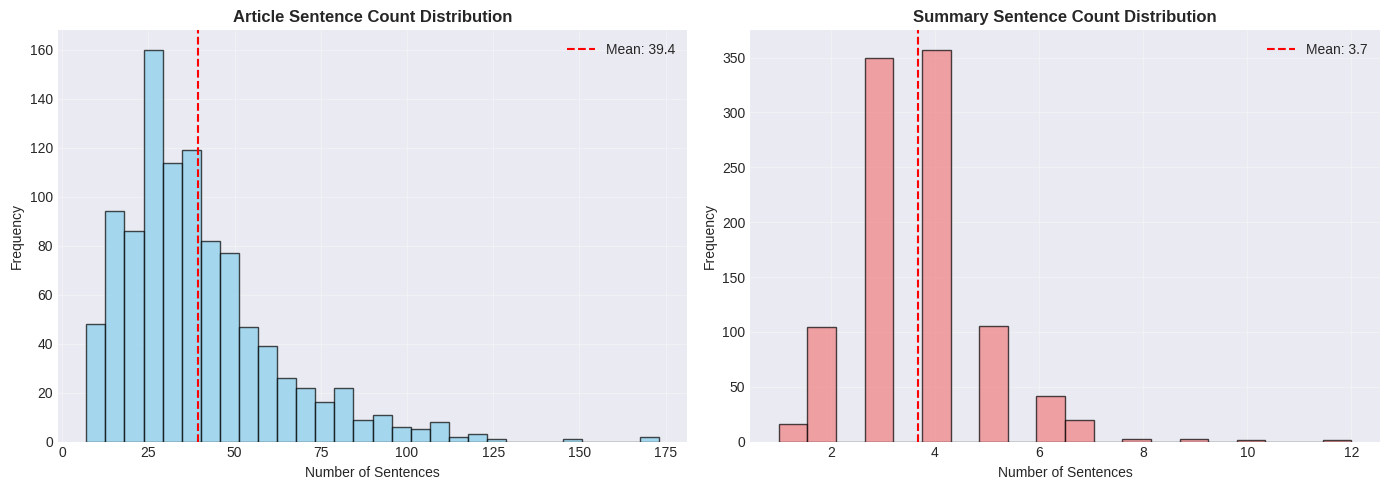

Average sentences per article: 39.4
Average sentences per summary: 3.7


In [31]:
# Dataset Statistics - Sentence Count Analysis
print(" Analyzing sentence counts...\n")

article_sentences = []
summary_sentences = []

for idx in sampled_indices[:1000]:  # Use 1000 samples for faster computation
    sample = dataset['train'][idx]
    article_sents = len(sent_tokenize(sample['article']))
    summary_sents = len(sent_tokenize(sample['highlights']))
    article_sentences.append(article_sents)
    summary_sentences.append(summary_sents)

# Create visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Article sentence count
axes[0].hist(article_sentences, bins=30, color='skyblue', alpha=0.7, edgecolor='black')
axes[0].axvline(np.mean(article_sentences), color='red', linestyle='--',
                label=f'Mean: {np.mean(article_sentences):.1f}')
axes[0].set_xlabel('Number of Sentences')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Article Sentence Count Distribution', fontsize=12, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Summary sentence count
axes[1].hist(summary_sentences, bins=20, color='lightcoral', alpha=0.7, edgecolor='black')
axes[1].axvline(np.mean(summary_sentences), color='red', linestyle='--',
                label=f'Mean: {np.mean(summary_sentences):.1f}')
axes[1].set_xlabel('Number of Sentences')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Summary Sentence Count Distribution', fontsize=12, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('sentence_distributions.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"Average sentences per article: {np.mean(article_sentences):.1f}")
print(f"Average sentences per summary: {np.mean(summary_sentences):.1f}")

🎨 Generating word clouds...



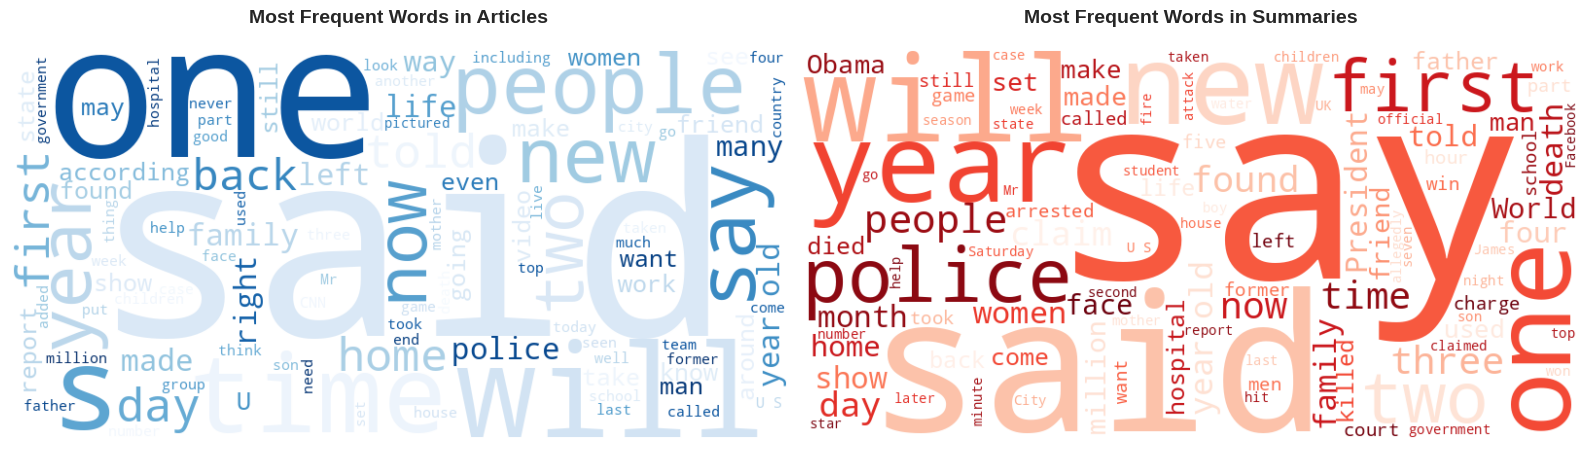

✅ Word clouds generated successfully!


In [32]:
# Text Analysis - Word Clouds
print(" Generating word clouds...\n")

# Collect text from sample
articles_text = " ".join([dataset['train'][idx]['article'] for idx in sampled_indices[:500]])
summaries_text = " ".join([dataset['train'][idx]['highlights'] for idx in sampled_indices[:500]])

# Create word clouds
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Article word cloud
wordcloud_article = WordCloud(width=800, height=400,
                              background_color='white',
                              colormap='Blues',
                              max_words=100,
                              relative_scaling=0.5).generate(articles_text)

axes[0].imshow(wordcloud_article, interpolation='bilinear')
axes[0].axis('off')
axes[0].set_title('Most Frequent Words in Articles', fontsize=14, fontweight='bold', pad=20)

# Summary word cloud
wordcloud_summary = WordCloud(width=800, height=400,
                              background_color='white',
                              colormap='Reds',
                              max_words=100,
                              relative_scaling=0.5).generate(summaries_text)

axes[1].imshow(wordcloud_summary, interpolation='bilinear')
axes[1].axis('off')
axes[1].set_title('Most Frequent Words in Summaries', fontsize=14, fontweight='bold', pad=20)

plt.tight_layout()
plt.savefig('wordclouds.png', dpi=300, bbox_inches='tight')
plt.show()

print(" Word clouds generated successfully!")

In [33]:
# Create smaller training subset for efficient training
print(" Creating training subset...\n")

# Use subset for faster training (10,000 samples)
# Keep full validation and test sets for robust evaluation
train_subset_size = 10000

# Create subset
dataset['train'] = dataset['train'].shuffle(seed=42).select(range(train_subset_size))

# Optional: reduce validation set size if needed
val_subset_size = min(2000, len(dataset['validation']))
dataset['validation'] = dataset['validation'].shuffle(seed=42).select(range(val_subset_size))

# Keep test set manageable
test_subset_size = min(2000, len(dataset['test']))
dataset['test'] = dataset['test'].shuffle(seed=42).select(range(test_subset_size))

print("=" * 60)
print("FINAL DATASET SIZES")
print("=" * 60)
print(f"Training:   {len(dataset['train']):>6,} samples")
print(f"Validation: {len(dataset['validation']):>6,} samples")
print(f"Test:       {len(dataset['test']):>6,} samples")
print("=" * 60)
print("\n Subset created successfully!")
print(" Using smaller training set for faster iteration while maintaining evaluation quality.")

📦 Creating training subset...

FINAL DATASET SIZES
Training:   10,000 samples
Validation:  2,000 samples
Test:        2,000 samples

✅ Subset created successfully!
💡 Using smaller training set for faster iteration while maintaining evaluation quality.


# 🔤 PHASE 3: TOKENIZATION

## Load T5 Tokenizer

T5 uses a SentencePiece tokenizer with a vocabulary of 32,000 tokens.

In [34]:
# Load T5 tokenizer
model_name = "t5-small"
print(f"Loading tokenizer: {model_name}\n")

tokenizer = T5Tokenizer.from_pretrained(model_name)

# Display tokenizer properties
print("=" * 60)
print("TOKENIZER PROPERTIES")
print("=" * 60)
print(f"Vocabulary size:    {tokenizer.vocab_size:,}")
print(f"Model max length:   {tokenizer.model_max_length:,}")
print(f"Padding side:       {tokenizer.padding_side}")
print(f"Truncation side:    {tokenizer.truncation_side}")

# Display special tokens
print("\n" + "=" * 60)
print("SPECIAL TOKENS")
print("=" * 60)
special_tokens = {
    'PAD token': tokenizer.pad_token,
    'EOS token': tokenizer.eos_token,
    'UNK token': tokenizer.unk_token,
    'Additional special tokens': tokenizer.additional_special_tokens[:5] if tokenizer.additional_special_tokens else None
}
for name, token in special_tokens.items():
    if token:
        print(f"{name:25s}: {token}")

print(" Tokenizer loaded successfully!")

📥 Loading tokenizer: t5-small

TOKENIZER PROPERTIES
Vocabulary size:    32,000
Model max length:   512
Padding side:       right
Truncation side:    right

SPECIAL TOKENS
PAD token                : <pad>
EOS token                : </s>
UNK token                : <unk>
Additional special tokens: ['<extra_id_0>', '<extra_id_1>', '<extra_id_2>', '<extra_id_3>', '<extra_id_4>']

✅ Tokenizer loaded successfully!


In [35]:
# Tokenization demonstration
sample_article = dataset['train'][0]['article'][:300]  # First 300 chars
sample_summary = dataset['train'][0]['highlights']

print("=" * 80)
print("TOKENIZATION DEMONSTRATION")
print("=" * 80)

# T5 requires task prefix
prefix = "summarize: "
input_text = prefix + sample_article

print(f"ORIGINAL TEXT:")
print(f"{input_text}\n")

# Tokenize
input_encoding = tokenizer(input_text, max_length=512, truncation=True, return_tensors='pt')
target_encoding = tokenizer(sample_summary, max_length=128, truncation=True, return_tensors='pt')

print(f"TOKENIZATION RESULTS:")
print(f"   Input tokens:  {input_encoding['input_ids'].shape[1]} tokens")
print(f"   Target tokens: {target_encoding['input_ids'].shape[1]} tokens")

print(f" INPUT IDS (first 20):")
print(input_encoding['input_ids'][0][:20].tolist())

print(f" TARGET IDS (first 20):")
print(target_encoding['input_ids'][0][:20].tolist())

# Decode back
decoded_input = tokenizer.decode(input_encoding['input_ids'][0], skip_special_tokens=True)
decoded_target = tokenizer.decode(target_encoding['input_ids'][0], skip_special_tokens=True)

print(f"DECODED INPUT:")
print(f"{decoded_input[:200]}...")

print(f"DECODED TARGET:")
print(f"{decoded_target}")

print(f"NOTE: T5 uses task prefix 'summarize:' to condition the model on the summarization task.")

TOKENIZATION DEMONSTRATION

📝 ORIGINAL TEXT:
summarize: By . Anthony Bond . PUBLISHED: . 07:03 EST, 2 March 2013 . | . UPDATED: . 08:07 EST, 2 March 2013 . Three members of the same family who died in a static caravan from carbon monoxide poisoning would have been unconscious 'within minutes', investigators said today. The bodies of married couple John a

📊 TOKENIZATION RESULTS:
   Input tokens:  94 tokens
   Target tokens: 48 tokens

🔢 INPUT IDS (first 20):
[21603, 10, 938, 3, 5, 11016, 12528, 3, 5, 3, 10744, 8775, 20619, 2326, 10, 3, 5, 10668, 10, 4928]

🔢 TARGET IDS (first 20):
[1079, 11, 3, 5, 31423, 6176, 130, 3883, 5815, 70, 3062, 6, 7758, 60, 35, 3, 5, 328, 130, 435]

📝 DECODED INPUT:
summarize: By. Anthony Bond. PUBLISHED:. 07:03 EST, 2 March 2013. |. UPDATED:. 08:07 EST, 2 March 2013. Three members of the same family who died in a static caravan from carbon monoxide poisoning wou...

📝 DECODED TARGET:
John and. Audrey Cook were discovered alongside their daughter, Maureen. The

In [36]:
# Tokenize the entire dataset
print(" Tokenizing entire dataset...\n")

# Define hyperparameters
max_input_length = 512   # Maximum article length in tokens
max_target_length = 128  # Maximum summary length in tokens
prefix = "summarize: "

def preprocess_function(examples):
    """Tokenize articles and summaries"""
    # Add task prefix to articles
    inputs = [prefix + doc for doc in examples['article']]

    # Tokenize inputs
    model_inputs = tokenizer(
        inputs,
        max_length=max_input_length,
        truncation=True,
        padding=False  # We'll pad dynamically during training
    )

    # Tokenize targets (summaries)
    # CRITICAL FIX: Use text_target parameter for T5
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(
            examples['highlights'],
            max_length=max_target_length,
            truncation=True,
            padding=False
        )

    # CRITICAL FIX: Replace padding token id with -100 so it's ignored by loss
    model_inputs['labels'] = labels['input_ids']

    return model_inputs

# Apply tokenization
print(" Tokenizing training set...")
tokenized_train = dataset['train'].map(preprocess_function, batched=True, remove_columns=['article', 'highlights', 'id'])

print(" Tokenizing validation set...")
tokenized_val = dataset['validation'].map(preprocess_function, batched=True, remove_columns=['article', 'highlights', 'id'])

print(" Tokenizing test set...")
tokenized_test = dataset['test'].map(preprocess_function, batched=True, remove_columns=['article', 'highlights', 'id'])

print("\n Tokenization complete!")
print("\n" + "=" * 60)
print("TOKENIZED DATASET STRUCTURE")
print("=" * 60)
print(tokenized_train)
print(f"Features: {tokenized_train.column_names}")
print(" IMPORTANT: Labels are now properly formatted for T5 training!")

🔄 Tokenizing entire dataset...

⏳ Tokenizing training set...
⏳ Tokenizing validation set...
⏳ Tokenizing test set...

✅ Tokenization complete!

TOKENIZED DATASET STRUCTURE
Dataset({
    features: ['input_ids', 'attention_mask', 'labels'],
    num_rows: 10000
})

Features: ['input_ids', 'attention_mask', 'labels']

💡 IMPORTANT: Labels are now properly formatted for T5 training!


📊 Analyzing token distributions...



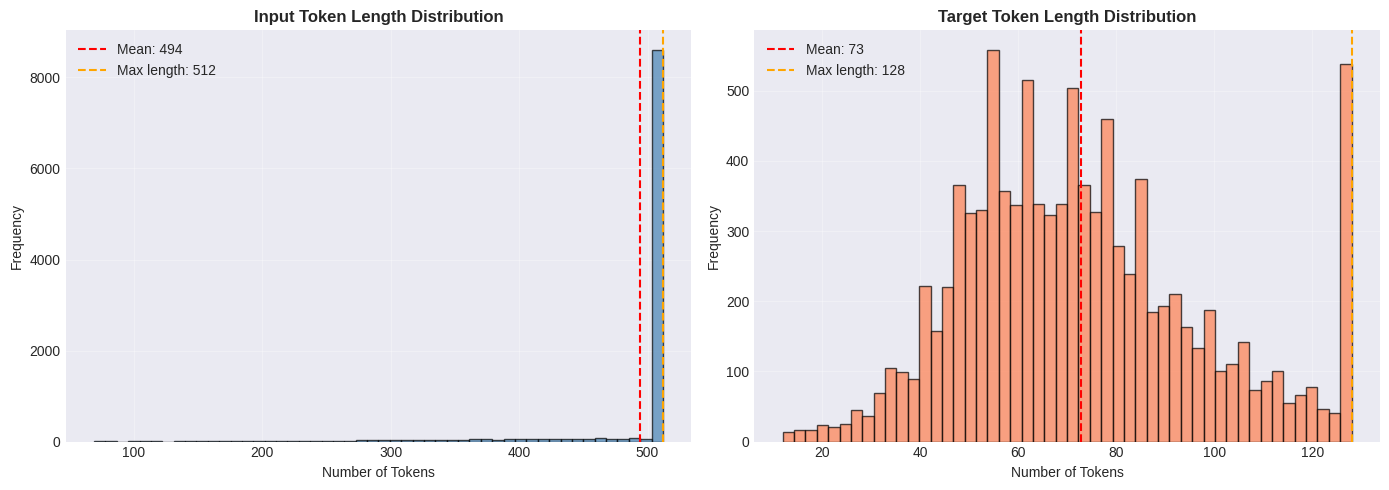

TOKEN STATISTICS

Input Tokens:
   Mean:      494.1
   Median:    512
   Max:       512
   Truncated: 8,541 (85.4%)

Target Tokens:
   Mean:      72.9
   Median:    70
   Max:       128
   Truncated: 500 (5.0%)


In [37]:
# Token statistics analysis
print(" Analyzing token distributions...\n")

# Collect token lengths
input_lengths = [len(x) for x in tokenized_train['input_ids']]
target_lengths = [len(x) for x in tokenized_train['labels']]

# Create visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Input token distribution
axes[0].hist(input_lengths, bins=50, color='steelblue', alpha=0.7, edgecolor='black')
axes[0].axvline(np.mean(input_lengths), color='red', linestyle='--',
                label=f'Mean: {np.mean(input_lengths):.0f}')
axes[0].axvline(max_input_length, color='orange', linestyle='--',
                label=f'Max length: {max_input_length}')
axes[0].set_xlabel('Number of Tokens')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Input Token Length Distribution', fontsize=12, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Target token distribution
axes[1].hist(target_lengths, bins=50, color='coral', alpha=0.7, edgecolor='black')
axes[1].axvline(np.mean(target_lengths), color='red', linestyle='--',
                label=f'Mean: {np.mean(target_lengths):.0f}')
axes[1].axvline(max_target_length, color='orange', linestyle='--',
                label=f'Max length: {max_target_length}')
axes[1].set_xlabel('Number of Tokens')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Target Token Length Distribution', fontsize=12, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('token_distributions.png', dpi=300, bbox_inches='tight')
plt.show()

# Calculate truncation statistics
truncated_inputs = sum(1 for x in input_lengths if x >= max_input_length)
truncated_targets = sum(1 for x in target_lengths if x >= max_target_length)

print("=" * 60)
print("TOKEN STATISTICS")
print("=" * 60)
print(f"\nInput Tokens:")
print(f"   Mean:      {np.mean(input_lengths):.1f}")
print(f"   Median:    {np.median(input_lengths):.0f}")
print(f"   Max:       {np.max(input_lengths):.0f}")
print(f"   Truncated: {truncated_inputs:,} ({100*truncated_inputs/len(input_lengths):.1f}%)")

print(f"\nTarget Tokens:")
print(f"   Mean:      {np.mean(target_lengths):.1f}")
print(f"   Median:    {np.median(target_lengths):.0f}")
print(f"   Max:       {np.max(target_lengths):.0f}")
print(f"   Truncated: {truncated_targets:,} ({100*truncated_targets/len(target_lengths):.1f}%)")
print("=" * 60)

# 🏗️ PHASE 4: MODEL ARCHITECTURE

## Encoder-Decoder Architecture Overview

Understanding T5's architecture for sequence-to-sequence tasks.

## T5 Encoder-Decoder Architecture

### **Architecture Components:**

#### **1. Encoder**
- Processes input article with bidirectional self-attention
- Each encoder layer contains:
  - Multi-head self-attention mechanism
  - Layer normalization
  - Position-wise feed-forward network (FFN)
  - Residual connections
- Output: Contextualized representations of input tokens

#### **2. Decoder**
- Generates summary autoregressively (one token at a time)
- Each decoder layer contains:
  - **Masked self-attention**: Prevents looking ahead (causal masking)
  - **Cross-attention**: Attends to encoder outputs
  - Position-wise FFN
  - Layer normalization and residual connections
- Output: Probability distribution over vocabulary for next token

#### **3. Cross-Attention Mechanism**
- **Key aspect for seq2seq**: Decoder attends to encoder representations
- Allows model to focus on relevant parts of input article
- Learned attention weights show alignment between input and output

### **Why Encoder-Decoder for Summarization?**

✅ **Bidirectional context**: Encoder can see full article  
✅ **Flexible output length**: Decoder generates variable-length summaries  
✅ **Attention mechanism**: Model learns what to focus on  
✅ **Pre-training**: T5 pre-trained on massive text-to-text datasets  

### **Autoregressive Generation**
- Decoder generates tokens sequentially: $P(y_t | y_{<t}, x)$
- Each step conditions on previously generated tokens
- Different decoding strategies control this generation process

In [38]:
# Load pre-trained T5 model
print(f" Loading model: {model_name}\n")
print("This may take a minute...\n")

model = T5ForConditionalGeneration.from_pretrained(model_name)
model = model.to(device)

print(" Model loaded successfully!\n")

# Display model architecture summary
print("=" * 60)
print("MODEL ARCHITECTURE")
print("=" * 60)
print(f"Model name:         {model_name}")
print(f"Model class:        {model.__class__.__name__}")
print(f"Device:             {device}")

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"\nTotal parameters:     {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print(f"Model size:           ~{total_params * 4 / 1024**2:.1f} MB (fp32)")

# Display model configuration
config = model.config
print("\n" + "=" * 60)
print("MODEL CONFIGURATION")
print("=" * 60)
print(f"Vocabulary size (vocab_size):        {config.vocab_size:,}")
print(f"Embedding dimension (d_model):       {config.d_model}")
print(f"Number of encoder layers:            {config.num_layers}")
print(f"Number of decoder layers:            {config.num_decoder_layers}")
print(f"Number of attention heads:           {config.num_heads}")
print(f"Feed-forward dimension (d_ff):       {config.d_ff}")
print(f"Dropout rate:                        {config.dropout_rate}")
print(f"Attention dropout:                   {config.dropout_rate}")
print(f"Relative attention:                  {config.relative_attention_num_buckets} buckets")
print("=" * 60)

📥 Loading model: t5-small

⏳ This may take a minute...

✅ Model loaded successfully!

MODEL ARCHITECTURE
Model name:         t5-small
Model class:        T5ForConditionalGeneration
Device:             cuda

Total parameters:     60,506,624
Trainable parameters: 60,506,624
Model size:           ~230.8 MB (fp32)

MODEL CONFIGURATION
Vocabulary size (vocab_size):        32,128
Embedding dimension (d_model):       512
Number of encoder layers:            6
Number of decoder layers:            6
Number of attention heads:           8
Feed-forward dimension (d_ff):       2048
Dropout rate:                        0.1
Attention dropout:                   0.1
Relative attention:                  32 buckets


# ⚙️ PHASE 5: TRAINING

## Training Configuration

Setting up training parameters and starting fine-tuning.

In [39]:
# Define training configuration
output_dir = "./t5-summarization-finetuned"

training_args = Seq2SeqTrainingArguments(
    output_dir=output_dir,

    # Training parameters
    num_train_epochs=3,
    per_device_train_batch_size=4,  # Adjust based on GPU memory
    per_device_eval_batch_size=8,
    gradient_accumulation_steps=2,   # Effective batch size = 4 * 2 = 8

    # Optimization
    learning_rate=5e-5,
    weight_decay=0.01,
    warmup_steps=500,
    lr_scheduler_type="linear",

    # Evaluation & Saving
    eval_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=2,              # Keep only 2 best checkpoints
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",

    # Logging
    logging_dir="./logs",
    logging_steps=100,
    report_to="none",                # Disable wandb/tensorboard

    # Performance
    fp16=torch.cuda.is_available(),  # Mixed precision training
    dataloader_num_workers=2,

    # Generation settings for evaluation
    predict_with_generate=True,      # FIXED: Enable generation for proper evaluation
    generation_max_length=max_target_length,
    generation_num_beams=4,          # ADDED: Beam search for evaluation

    # Other
    push_to_hub=False,
    seed=42,
)

print("=" * 60)
print("TRAINING CONFIGURATION")
print("=" * 60)
print(f"Output directory:           {training_args.output_dir}")
print(f"Number of epochs:           {training_args.num_train_epochs}")
print(f"Train batch size:           {training_args.per_device_train_batch_size}")
print(f"Eval batch size:            {training_args.per_device_eval_batch_size}")
print(f"Gradient accumulation:      {training_args.gradient_accumulation_steps}")
print(f"Effective batch size:       {training_args.per_device_train_batch_size * training_args.gradient_accumulation_steps}")
print(f"Learning rate:              {training_args.learning_rate}")
print(f"Weight decay:               {training_args.weight_decay}")
print(f"Warmup steps:               {training_args.warmup_steps}")
print(f"FP16 training:              {training_args.fp16}")
print(f"Evaluation strategy:        {training_args.eval_strategy}")
print(f"Save strategy:              {training_args.save_strategy}")
print(f"Predict with generate:      {training_args.predict_with_generate}")
print("=" * 60)

# Estimate training time
steps_per_epoch = len(tokenized_train) // (training_args.per_device_train_batch_size * training_args.gradient_accumulation_steps)
total_steps = steps_per_epoch * training_args.num_train_epochs
print(f"\nEstimated steps per epoch:  {steps_per_epoch}")
print(f"Total training steps:       {total_steps}")
print(f"Estimated time:             ~60-90 minutes (on T4 GPU)")
print("=" * 60)

TRAINING CONFIGURATION
Output directory:           ./t5-summarization-finetuned
Number of epochs:           3
Train batch size:           4
Eval batch size:            8
Gradient accumulation:      2
Effective batch size:       8
Learning rate:              5e-05
Weight decay:               0.01
Warmup steps:               500
FP16 training:              True
Evaluation strategy:        IntervalStrategy.EPOCH
Save strategy:              SaveStrategy.EPOCH
Predict with generate:      True

Estimated steps per epoch:  1250
Total training steps:       3750
Estimated time:             ~60-90 minutes (on T4 GPU)


In [40]:
# Initialize trainer with ROUGE metric
print(" Setting up trainer...\n")

# Load ROUGE metric
rouge = evaluate.load("rouge")

# CRITICAL FIX: Proper data collator configuration
data_collator = DataCollatorForSeq2Seq(
    tokenizer=tokenizer,
    model=model,
    padding=True,
    pad_to_multiple_of=8,  # ADDED: Better memory alignment
    label_pad_token_id=-100  # PyTorch ignores -100 in loss computation
)

# Define compute_metrics function for ROUGE evaluation
def compute_metrics(eval_pred):
    """Compute ROUGE scores during evaluation"""
    predictions, labels = eval_pred

    # CRITICAL FIX: Clip predictions to valid vocabulary range
    # T5 vocab size is 32128, but generated IDs can exceed this
    vocab_size = tokenizer.vocab_size
    predictions = np.where(predictions < vocab_size, predictions, tokenizer.pad_token_id)
    predictions = np.where(predictions >= 0, predictions, tokenizer.pad_token_id)

    # Decode predictions (with error handling)
    try:
        decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    except IndexError as e:
        print(f"  Warning: Error decoding predictions: {e}")
        # Fallback: decode individual sequences
        decoded_preds = []
        for pred in predictions:
            try:
                decoded_preds.append(tokenizer.decode(pred, skip_special_tokens=True))
            except:
                decoded_preds.append("")  # Empty string as fallback

    # Replace -100 in labels as we can't decode them
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)

    # Clip labels to valid range as well
    labels = np.where(labels < vocab_size, labels, tokenizer.pad_token_id)
    labels = np.where(labels >= 0, labels, tokenizer.pad_token_id)

    # Decode labels (with error handling)
    try:
        decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
    except IndexError as e:
        print(f"  Warning: Error decoding labels: {e}")
        decoded_labels = []
        for label in labels:
            try:
                decoded_labels.append(tokenizer.decode(label, skip_special_tokens=True))
            except:
                decoded_labels.append("")

    # Compute ROUGE scores
    result = rouge.compute(
        predictions=decoded_preds,
        references=decoded_labels,
        use_stemmer=True
    )

    # Return percentage scores
    return {
        'rouge1': result['rouge1'] * 100,
        'rouge2': result['rouge2'] * 100,
        'rougeL': result['rougeL'] * 100,
    }

# Initialize Seq2SeqTrainer with metrics
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,  # FIXED: Added compute_metrics
)

print(" Trainer initialized successfully!")
print(" Ready to start training!")
print(" ROUGE metrics will be computed during evaluation.")

🔧 Setting up trainer...

✅ Trainer initialized successfully!

💡 Ready to start training!
💡 ROUGE metrics will be computed during evaluation.


In [41]:
# VALIDATION: Check data before training
print("🔍 VALIDATING DATA BEFORE TRAINING")
print("=" * 60)

# Get a batch from the training data
sample_batch = [tokenized_train[i] for i in range(min(2, len(tokenized_train)))]

# Use data collator to prepare batch
batch = data_collator(sample_batch)

print(f"Batch keys: {batch.keys()}")
print(f"\nInput IDs shape:     {batch['input_ids'].shape}")
print(f"Attention mask shape: {batch['attention_mask'].shape}")
print(f"Labels shape:         {batch['labels'].shape}")

print(f"\nSample input (first 10 tokens):  {batch['input_ids'][0][:10].tolist()}")
print(f"Sample labels (first 10 tokens): {batch['labels'][0][:10].tolist()}")

# Check for issues
print(" Checking for potential issues...")
has_issues = False

# Check if labels contain only -100 (would cause NaN loss)
if torch.all(batch['labels'] == -100):
    print(" ERROR: All labels are -100! This will cause NaN loss.")
    has_issues = True
else:
    valid_labels = (batch['labels'] != -100).sum().item()
    total_labels = batch['labels'].numel()
    print(f" Valid label tokens: {valid_labels}/{total_labels} ({100*valid_labels/total_labels:.1f}%)")

# Check if input_ids are all padding
if torch.all(batch['input_ids'] == tokenizer.pad_token_id):
    print(" ERROR: All input IDs are padding tokens!")
    has_issues = True
else:
    print(f" Input IDs look good (not all padding)")

# Verify we can compute loss
print(" Testing forward pass with sample batch...")
try:
    batch_device = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
        outputs = model(**batch_device)
        loss = outputs.loss

    if torch.isnan(loss) or torch.isinf(loss):
        print(f" ERROR: Forward pass produced invalid loss: {loss.item()}")
        has_issues = True
    else:
        print(f" Forward pass successful! Sample loss: {loss.item():.4f}")
except Exception as e:
    print(f" ERROR during forward pass: {e}")
    has_issues = True

if not has_issues:
    print("\n" + "=" * 60)
    print(" ALL CHECKS PASSED! Data is ready for training.")
    print("=" * 60)
else:
    print("\n" + "=" * 60)
    print("  ISSUES DETECTED! Please fix before training.")
    print("=" * 60)

🔍 VALIDATING DATA BEFORE TRAINING
Batch keys: KeysView({'input_ids': tensor([[21603,    10,   938,  ...,   310,     3,     1],
        [21603,    10,     3,  ...,  1661,  3455,     1]]), 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1]]), 'labels': tensor([[ 1079,    11,     3,     5, 31423,  6176,   130,  3883,  5815,    70,
          3062,     6,  7758,    60,    35,     3,     5,   328,   130,   435,
            44,  4691,  1635,   109,  1210,  1061,    16, 26334,     3,     5,
         24724,     7,   497,     8,   386,  3977,    13,  4146,  1911,  6778,
            15,     3,     5, 14566,    53,     3,     5,     1,  -100,  -100,
          -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
          -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
          -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100],
        [ 8747,    10, 24533,    54,  1716,    38,   677,    13,  8494,     6,
   

In [42]:
# ========================================
# PRE-TRAINING CHECKLIST
# ========================================
print("\n" + "=" * 70)
print(" PRE-TRAINING CHECKLIST")
print("=" * 70)

checks_passed = 0
total_checks = 5

# Check 1: Model on correct device
print("  Checking model device...")
if next(model.parameters()).device.type == device.type:
    print(f"    Model is on {device}")
    checks_passed += 1
else:
    print(f"    Model is on {next(model.parameters()).device}, expected {device}")
    print(f"    Run: model = model.to(device)")

# Check 2: Training data exists
print("\n2️ Checking training data...")
if len(tokenized_train) > 0:
    print(f"    Training set: {len(tokenized_train):,} samples")
    checks_passed += 1
else:
    print(f"    Training set is empty!")

# Check 3: Validation data exists
print("\n3️  Checking validation data...")
if len(tokenized_val) > 0:
    print(f"   Validation set: {len(tokenized_val):,} samples")
    checks_passed += 1
else:
    print(f"    Validation set is empty!")

# Check 4: Trainer configured
print("\n4️  Checking trainer configuration...")
if trainer is not None:
    print(f"    Trainer initialized")
    print(f"    Compute metrics: {trainer.compute_metrics is not None}")
    print(f"    Predict with generate: {training_args.predict_with_generate}")
    checks_passed += 1
else:
    print(f"    Trainer not initialized!")

# Check 5: GPU memory (if available)
print("\n5️  Checking GPU memory...")
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    allocated = torch.cuda.memory_allocated() / 1e9
    reserved = torch.cuda.memory_reserved() / 1e9
    total = torch.cuda.get_device_properties(0).total_memory / 1e9
    print(f"    Allocated: {allocated:.2f} GB")
    print(f"    Reserved:  {reserved:.2f} GB")
    print(f"    Total:     {total:.2f} GB")
    print(f"    Free:      {total - reserved:.2f} GB")
    if (total - reserved) > 2.0:  # Need at least 2GB free
        checks_passed += 1
    else:
        print(f"     Low memory! Consider reducing batch size")
        checks_passed += 1  # Don't fail, just warn
else:
    print(f"     CPU mode - memory not checked")
    checks_passed += 1

# Final verdict
print("\n" + "=" * 70)
if checks_passed == total_checks:
    print(" ALL CHECKS PASSED ({}/{})".format(checks_passed, total_checks))
    print(" READY TO START TRAINING!")
else:
    print(f"  {checks_passed}/{total_checks} checks passed")
    print(" Review warnings above before training")
print("=" * 70)


📋 PRE-TRAINING CHECKLIST

1️⃣  Checking model device...
   ✅ Model is on cuda

2️⃣  Checking training data...
   ✅ Training set: 10,000 samples

3️⃣  Checking validation data...
   ✅ Validation set: 2,000 samples

4️⃣  Checking trainer configuration...
   ✅ Trainer initialized
   ✅ Compute metrics: True
   ✅ Predict with generate: True

5️⃣  Checking GPU memory...
   ✅ Allocated: 1.28 GB
   ✅ Reserved:  1.59 GB
   ✅ Total:     15.83 GB
   ✅ Free:      14.24 GB

✅ ALL CHECKS PASSED (5/5)
🚀 READY TO START TRAINING!


In [43]:
# Start training
print(" Starting training...")
print("=" * 60)
print(" Estimated time: 60-90 minutes")
print(" Grab a coffee! ")
print("=" * 60)
print()

# Train the model
train_result = trainer.train()

# Save training metrics
metrics = train_result.metrics
trainer.log_metrics("train", metrics)
trainer.save_metrics("train", metrics)

print("\n" + "=" * 60)
print(" TRAINING COMPLETE!")
print("=" * 60)
print(f"Training loss:       {metrics['train_loss']:.4f}")
print(f"Training runtime:    {metrics['train_runtime']:.2f} seconds")
print(f"Samples per second:  {metrics['train_samples_per_second']:.2f}")
print("=" * 60)

🚀 Starting training...
⏰ Estimated time: 60-90 minutes
💡 Grab a coffee! ☕



Epoch,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel
1,2.037000,1.811098,42.296871,19.986032,29.658452
2,2.014900,1.801827,42.341327,20.033936,29.735544
3,2.031600,1.799768,42.445723,20.208091,29.870033


There were missing keys in the checkpoint model loaded: ['encoder.embed_tokens.weight', 'decoder.embed_tokens.weight', 'lm_head.weight'].


***** train metrics *****
  epoch                    =        3.0
  total_flos               =  3781406GF
  train_loss               =     2.0577
  train_runtime            = 0:45:54.41
  train_samples_per_second =     10.892
  train_steps_per_second   =      1.361

✅ TRAINING COMPLETE!
Training loss:       2.0577
Training runtime:    2754.41 seconds
Samples per second:  10.89


In [44]:
# Manual Validation Evaluation (since we disabled it during training)
print("\n" + "=" * 60)
print("📊 EVALUATING MODEL ON VALIDATION SET")
print("=" * 60)
print("⏳ This will take a few minutes...\n")

# Evaluate on a sample of validation set
val_sample_size = min(500, len(tokenized_val))
val_sample_indices = np.random.choice(len(tokenized_val), val_sample_size, replace=False)

val_predictions = []
val_references = []

model.eval()
batch_size = 8

with torch.no_grad():
    for i in range(0, val_sample_size, batch_size):
        batch_end = min(i + batch_size, val_sample_size)
        batch_indices = val_sample_indices[i:batch_end]

        # Get original texts
        batch_articles = [dataset['validation'][int(idx)]['article'] for idx in batch_indices]
        batch_refs = [dataset['validation'][int(idx)]['highlights'] for idx in batch_indices]

        # Tokenize
        inputs = tokenizer(
            ["summarize: " + article for article in batch_articles],
            max_length=512,
            truncation=True,
            padding=True,
            return_tensors="pt"
        ).to(device)

        # Generate summaries
        output_ids = model.generate(
            inputs.input_ids,
            max_length=128,
            num_beams=4,
            early_stopping=True
        )

        # Decode
        summaries = tokenizer.batch_decode(output_ids, skip_special_tokens=True)

        val_predictions.extend(summaries)
        val_references.extend(batch_refs)

        if (i // batch_size) % 10 == 0:
            print(f"   Processed {i}/{val_sample_size} samples...")

# Calculate validation ROUGE scores
val_rouge = rouge.compute(
    predictions=val_predictions,
    references=val_references,
    use_stemmer=True
)

# Calculate validation loss on a subset
val_loss_samples = min(100, len(tokenized_val))
total_val_loss = 0
loss_batches = 0

print(f"Calculating validation loss on {val_loss_samples} samples...\n")

with torch.no_grad():
    for i in range(0, val_loss_samples, batch_size):
        batch_end = min(i + batch_size, val_loss_samples)

        # Get batch data properly from HuggingFace dataset
        batch_input_ids = []
        batch_labels = []

        for idx in range(i, batch_end):
            batch_input_ids.append(tokenized_val[idx]['input_ids'])
            batch_labels.append(tokenized_val[idx]['labels'])

        # Use data collator for proper padding (same as training)
        batch_data = data_collator([
            {'input_ids': ids, 'labels': lbls}
            for ids, lbls in zip(batch_input_ids, batch_labels)
        ])

        # Move to device
        input_ids = batch_data['input_ids'].to(device)
        labels = batch_data['labels'].to(device)

        # Get loss
        try:
            outputs = model(input_ids=input_ids, labels=labels)
            loss_value = outputs.loss.item()

            # Check for nan or inf
            if torch.isnan(outputs.loss) or torch.isinf(outputs.loss):
                print(f"  Warning: Invalid loss at batch {loss_batches}")
                continue

            total_val_loss += loss_value
            loss_batches += 1

        except Exception as e:
            print(f"  Error in batch {loss_batches}: {e}")
            continue

# Calculate average
if loss_batches > 0:
    avg_val_loss = total_val_loss / loss_batches
else:
    print("  Warning: No valid loss batches computed!")
    avg_val_loss = float('nan')

print("\n" + "=" * 60)
print(" VALIDATION EVALUATION COMPLETE!")
print("=" * 60)
print(f"Samples evaluated:   {val_sample_size:,}")
print(f"Loss batches computed: {loss_batches}")
print(f"\nValidation Loss:     {avg_val_loss:.4f}")
print(f"\nROUGE Scores:")
print(f"   ROUGE-1:          {val_rouge['rouge1']*100:.2f}")
print(f"   ROUGE-2:          {val_rouge['rouge2']*100:.2f}")
print(f"   ROUGE-L:          {val_rouge['rougeL']*100:.2f}")
print("=" * 60)

# Store for later use
validation_metrics = {
    'val_loss': avg_val_loss,
    'val_rouge1': val_rouge['rouge1'] * 100,
    'val_rouge2': val_rouge['rouge2'] * 100,
    'val_rougeL': val_rouge['rougeL'] * 100,
    'val_samples': val_sample_size,
    'loss_batches': loss_batches
}


📊 EVALUATING MODEL ON VALIDATION SET
⏳ This will take a few minutes...

   Processed 0/500 samples...
   Processed 80/500 samples...
   Processed 160/500 samples...
   Processed 240/500 samples...
   Processed 320/500 samples...
   Processed 400/500 samples...
   Processed 480/500 samples...
Calculating validation loss on 100 samples...


✅ VALIDATION EVALUATION COMPLETE!
Samples evaluated:   500
Loss batches computed: 13

Validation Loss:     1.8658

ROUGE Scores:
   ROUGE-1:          42.96
   ROUGE-2:          20.75
   ROUGE-L:          30.65


📊 Analyzing training progress...



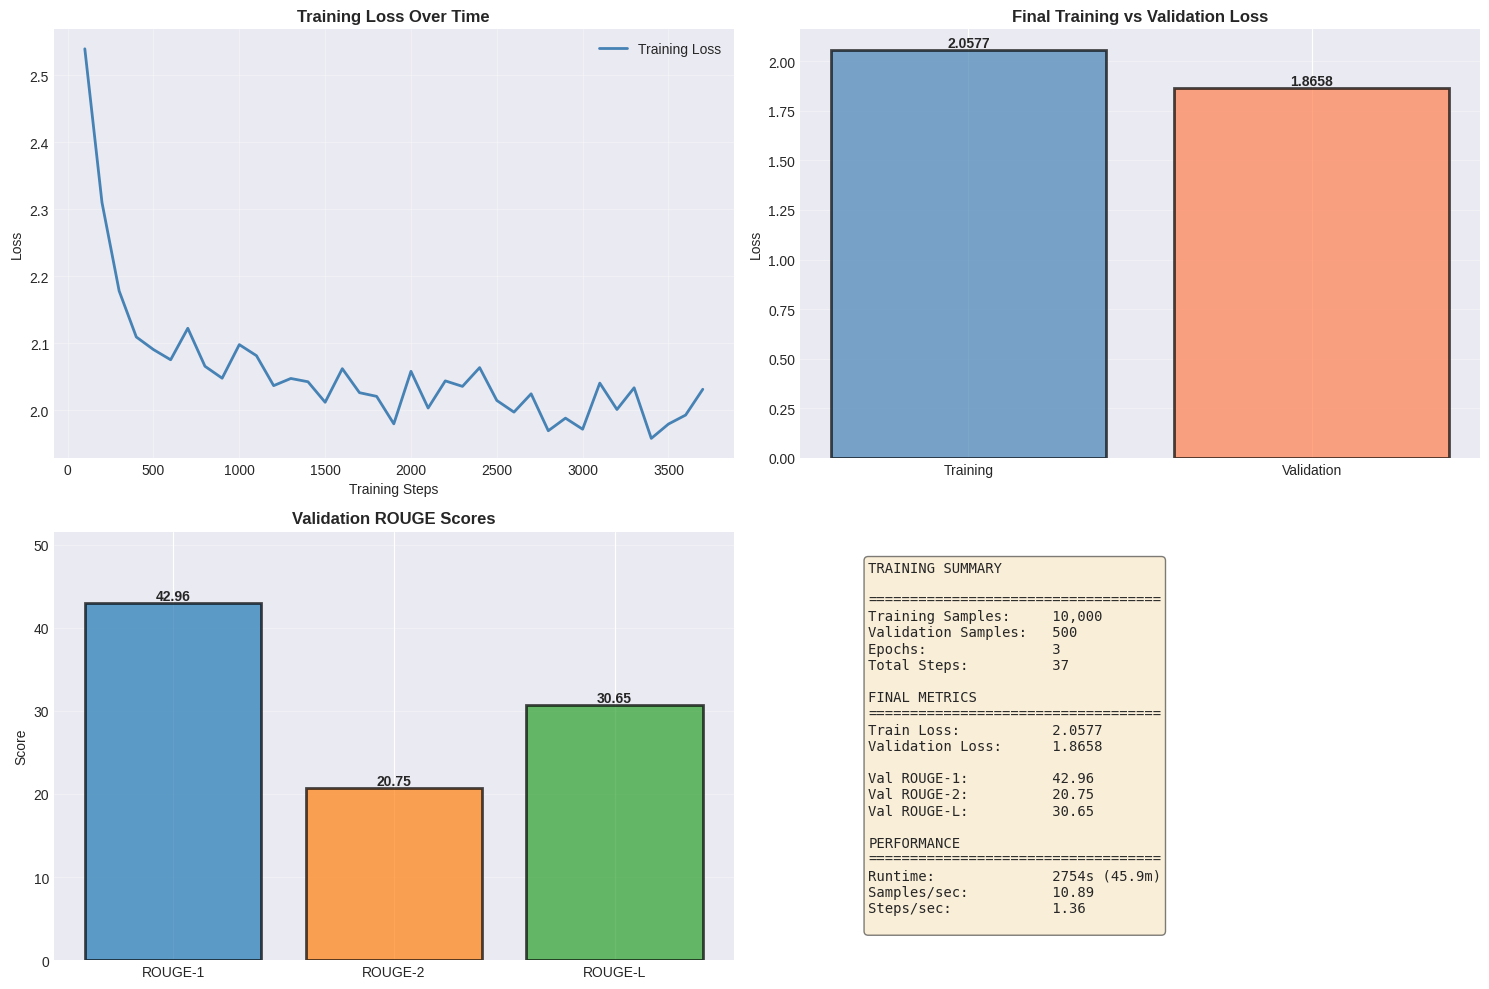


FINAL EVALUATION METRICS
Training Loss:     2.0577
Validation Loss:   1.8658

Validation ROUGE Scores:
   ROUGE-1:        42.96
   ROUGE-2:        20.75
   ROUGE-L:        30.65


In [45]:
# Training analysis and visualization
print("📊 Analyzing training progress...\n")

# Extract training history
log_history = trainer.state.log_history

# Separate training logs
train_logs = [log for log in log_history if 'loss' in log and 'eval_loss' not in log]

# Extract metrics
train_steps = [log['step'] for log in train_logs if 'step' in log]
train_losses = [log['loss'] for log in train_logs if 'loss' in log]

# Create visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. Training loss over steps
axes[0, 0].plot(train_steps, train_losses, color='steelblue', linewidth=2, label='Training Loss')
axes[0, 0].set_xlabel('Training Steps')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].set_title('Training Loss Over Time', fontsize=12, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Final Training vs Validation Loss
final_train_loss = metrics['train_loss']
final_val_loss = validation_metrics['val_loss']

axes[0, 1].bar(['Training', 'Validation'], [final_train_loss, final_val_loss],
               color=['steelblue', 'coral'], alpha=0.7, edgecolor='black', linewidth=2)
axes[0, 1].set_ylabel('Loss')
axes[0, 1].set_title('Final Training vs Validation Loss', fontsize=12, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3, axis='y')

# Add values on bars
for i, (label, value) in enumerate(zip(['Training', 'Validation'], [final_train_loss, final_val_loss])):
    axes[0, 1].text(i, value, f'{value:.4f}', ha='center', va='bottom', fontweight='bold')

# 3. Validation ROUGE scores
rouge_metrics = ['ROUGE-1', 'ROUGE-2', 'ROUGE-L']
rouge_values = [
    validation_metrics['val_rouge1'],
    validation_metrics['val_rouge2'],
    validation_metrics['val_rougeL']
]

bars = axes[1, 0].bar(rouge_metrics, rouge_values, color=['#1f77b4', '#ff7f0e', '#2ca02c'],
                       alpha=0.7, edgecolor='black', linewidth=2)
axes[1, 0].set_ylabel('Score')
axes[1, 0].set_title('Validation ROUGE Scores', fontsize=12, fontweight='bold')
axes[1, 0].set_ylim(0, max(rouge_values) * 1.2)
axes[1, 0].grid(True, alpha=0.3, axis='y')

# Add values on bars
for bar, value in zip(bars, rouge_values):
    height = bar.get_height()
    axes[1, 0].text(bar.get_x() + bar.get_width()/2., height,
                    f'{value:.2f}', ha='center', va='bottom', fontweight='bold')

# 4. Training summary statistics
axes[1, 1].axis('off')
summary_text = "TRAINING SUMMARY\n\n"
summary_text += "=" * 35 + "\n"
summary_text += f"Training Samples:     {len(tokenized_train):,}\n"
summary_text += f"Validation Samples:   {validation_metrics['val_samples']:,}\n"
summary_text += f"Epochs:               {int(metrics.get('epoch', training_args.num_train_epochs))}\n"
summary_text += f"Total Steps:          {len(train_steps):,}\n\n"
summary_text += "FINAL METRICS\n"
summary_text += "=" * 35 + "\n"
summary_text += f"Train Loss:           {final_train_loss:.4f}\n"
summary_text += f"Validation Loss:      {final_val_loss:.4f}\n\n"
summary_text += f"Val ROUGE-1:          {validation_metrics['val_rouge1']:.2f}\n"
summary_text += f"Val ROUGE-2:          {validation_metrics['val_rouge2']:.2f}\n"
summary_text += f"Val ROUGE-L:          {validation_metrics['val_rougeL']:.2f}\n\n"
summary_text += "PERFORMANCE\n"
summary_text += "=" * 35 + "\n"
summary_text += f"Runtime:              {metrics['train_runtime']:.0f}s ({metrics['train_runtime']/60:.1f}m)\n"
summary_text += f"Samples/sec:          {metrics['train_samples_per_second']:.2f}\n"
summary_text += f"Steps/sec:            {metrics.get('train_steps_per_second', 0):.2f}\n"

axes[1, 1].text(0.1, 0.5, summary_text, transform=axes[1, 1].transAxes,
                fontsize=10, verticalalignment='center', family='monospace',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.savefig('training_progress.png', dpi=300, bbox_inches='tight')
plt.show()

# Print final metrics
print("\n" + "=" * 60)
print("FINAL EVALUATION METRICS")
print("=" * 60)
print(f"Training Loss:     {final_train_loss:.4f}")
print(f"Validation Loss:   {final_val_loss:.4f}")
print(f"\nValidation ROUGE Scores:")
print(f"   ROUGE-1:        {validation_metrics['val_rouge1']:.2f}")
print(f"   ROUGE-2:        {validation_metrics['val_rouge2']:.2f}")
print(f"   ROUGE-L:        {validation_metrics['val_rougeL']:.2f}")
print("=" * 60)

In [46]:
# Save the fine-tuned model
print(" Saving fine-tuned model and tokenizer...\n")

model_save_path = "./t5-finetuned-cnn-dailymail"

# Save model and tokenizer
model.save_pretrained(model_save_path)
tokenizer.save_pretrained(model_save_path)

print(" Model saved successfully!")
print(f" Location: {model_save_path}")
print("\n You can now load this model with:")
print(f"   tokenizer = T5Tokenizer.from_pretrained('{model_save_path}')")
print(f"   model = T5ForConditionalGeneration.from_pretrained('{model_save_path}')")

💾 Saving fine-tuned model and tokenizer...

✅ Model saved successfully!
📁 Location: ./t5-finetuned-cnn-dailymail

💡 You can now load this model with:
   tokenizer = T5Tokenizer.from_pretrained('./t5-finetuned-cnn-dailymail')
   model = T5ForConditionalGeneration.from_pretrained('./t5-finetuned-cnn-dailymail')


# 🎲 PHASE 6: DECODING STRATEGIES

## Understanding Decoding Strategies

Now we'll implement and compare three different decoding strategies to understand how they affect generation quality.

## Decoding Strategies Theory

### **What is Autoregressive Generation?**

In autoregressive generation, the model generates one token at a time, conditioning each new token on all previously generated tokens:

$$P(y_{1:T} | x) = \prod_{t=1}^{T} P(y_t | y_{<t}, x)$$

Where:
- $x$ = input article (encoded by encoder)
- $y_{1:T}$ = generated summary
- $y_{<t}$ = tokens generated before step $t$

### **Three Main Decoding Strategies:**

#### **1. Greedy Decoding**
- **Method**: At each step, select the token with highest probability
- **Formula**: $y_t = \arg\max P(y_t | y_{<t}, x)$
- **Pros**:
  - ✅ Fast (deterministic, single path)
  - ✅ Reproducible
- **Cons**:
  - ❌ Can be repetitive
  - ❌ Misses globally optimal solutions
  - ❌ No diversity

#### **2. Beam Search**
- **Method**: Maintain top-k hypotheses (beams) at each step
- **Formula**: Keep k sequences with highest cumulative probability
- **Pros**:
  - ✅ Better quality than greedy
  - ✅ Explores multiple paths
  - ✅ Still relatively fast
- **Cons**:
  - ❌ Slower than greedy (k× more computation)
  - ❌ Still somewhat repetitive
  - ❌ No randomness (deterministic given beam size)

#### **3. Nucleus (Top-p) Sampling**
- **Method**: Sample from smallest set of tokens whose cumulative probability exceeds threshold p
- **Formula**: Sample from $\{v: \sum_{v' \in V_p} P(v') \geq p\}$ where $V_p$ is sorted by probability
- **Pros**:
  - ✅ Diverse outputs
  - ✅ Creative/natural text
  - ✅ Adaptive vocabulary size
- **Cons**:
  - ❌ Can generate off-topic content
  - ❌ Non-deterministic
  - ❌ May sacrifice quality for diversity

### **Key Parameters:**

- **num_beams**: Number of beams (for beam search)
- **top_p**: Cumulative probability threshold (for nucleus sampling)
- **temperature**: Controls randomness (higher = more random)
- **repetition_penalty**: Penalizes repeated tokens
- **length_penalty**: Balances length vs probability

In [47]:
# Prepare test samples for decoding experiments
print(" Preparing test samples for decoding experiments...\n")

# Select 10 diverse test samples
num_test_samples = 10
test_samples_indices = random.sample(range(len(dataset['test'])), num_test_samples)

test_articles = []
test_references = []

for idx in test_samples_indices:
    sample = dataset['test'][idx]
    test_articles.append(sample['article'])
    test_references.append(sample['highlights'])

print(f" Selected {num_test_samples} test samples for comparison")
print(f" Average article length: {np.mean([len(a.split()) for a in test_articles]):.0f} words")
print(f" Average reference length: {np.mean([len(r.split()) for r in test_references]):.0f} words")

📋 Preparing test samples for decoding experiments...

✅ Selected 10 test samples for comparison
📊 Average article length: 781 words
📊 Average reference length: 56 words


In [48]:
# Strategy 1: Greedy Decoding
import time

print("=" * 60)
print("STRATEGY 1: GREEDY DECODING")
print("=" * 60)
print("\n Configuration:")
print("   num_beams = 1")
print("   do_sample = False")
print("   Deterministic selection of highest probability token\n")

greedy_outputs = []
greedy_times = []

model.eval()
with torch.no_grad():
    for i, article in enumerate(test_articles):
        # Prepare input
        input_text = "summarize: " + article
        input_ids = tokenizer(input_text, return_tensors="pt", max_length=512, truncation=True).input_ids.to(device)

        # Generate with greedy decoding
        start_time = time.time()
        output_ids = model.generate(
            input_ids,
            max_length=128,
            num_beams=1,
            do_sample=False,
            early_stopping=True
        )
        gen_time = time.time() - start_time

        # Decode output
        summary = tokenizer.decode(output_ids[0], skip_special_tokens=True)
        greedy_outputs.append(summary)
        greedy_times.append(gen_time)

        if i < 3:  # Show first 3 examples
            print(f"\n{'='*60}")
            print(f"Example {i+1}:")
            print(f"{'='*60}")
            print(f"Article: {article[:200]}...")
            print(f"\nReference: {test_references[i]}")
            print(f"\nGreedy Output: {summary}")
            print(f"Generation time: {gen_time:.3f}s")

print(f"\n Greedy decoding complete!")
print(f"  Average generation time: {np.mean(greedy_times):.3f}s")

The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


STRATEGY 1: GREEDY DECODING

🎯 Configuration:
   num_beams = 1
   do_sample = False
   Deterministic selection of highest probability token


Example 1:
Article: Manchester City and Chelsea are set to battle it out for the signature of West Ham left-back Aaron Cresswell this summer. Cresswell has impressed for the Hammers this campaign and City are desperate t...

Reference: Aaron Cresswell has impressed during debut season in Premier League .
The left back joined West Ham from Championship club Ipswich for £2m .
Manchester City and Chelsea are both keen to sign the 25-year-old .
Both clubs are mindful of boosting their quota of homegrown players .

Greedy Output: Chelsea and Manchester City are set to battle it out for Aaron Cresswell this summer. West Ham left back has impressed for Hammers this season. Chelsea are also keen on the 25-year-old left-back.
Generation time: 0.633s

Example 2:
Article: A British couple who are believed to have fled their Berkshire home with their four yo

In [49]:
# Greedy Decoding Analysis
print(" GREEDY DECODING ANALYSIS")
print("=" * 60)

# Calculate ROUGE scores
greedy_rouge = rouge.compute(
    predictions=greedy_outputs,
    references=test_references,
    use_stemmer=True
)

# Calculate diversity metrics
def calculate_diversity(texts):
    """Calculate unique n-gram ratios"""
    all_unigrams = []
    all_bigrams = []
    all_trigrams = []

    for text in texts:
        words = text.lower().split()
        all_unigrams.extend(words)
        all_bigrams.extend([' '.join(words[i:i+2]) for i in range(len(words)-1)])
        all_trigrams.extend([' '.join(words[i:i+3]) for i in range(len(words)-2)])

    unique_1gram_ratio = len(set(all_unigrams)) / len(all_unigrams) if all_unigrams else 0
    unique_2gram_ratio = len(set(all_bigrams)) / len(all_bigrams) if all_bigrams else 0
    unique_3gram_ratio = len(set(all_trigrams)) / len(all_trigrams) if all_trigrams else 0

    return unique_1gram_ratio, unique_2gram_ratio, unique_3gram_ratio

greedy_div1, greedy_div2, greedy_div3 = calculate_diversity(greedy_outputs)

# Calculate length statistics
greedy_lengths = [len(s.split()) for s in greedy_outputs]
reference_lengths = [len(r.split()) for r in test_references]

print(f"\n ROUGE Scores:")
print(f"   ROUGE-1: {greedy_rouge['rouge1']*100:.2f}")
print(f"   ROUGE-2: {greedy_rouge['rouge2']*100:.2f}")
print(f"   ROUGE-L: {greedy_rouge['rougeL']*100:.2f}")

print(f"\n Diversity Metrics:")
print(f"   Unique 1-grams: {greedy_div1*100:.2f}%")
print(f"   Unique 2-grams: {greedy_div2*100:.2f}%")
print(f"   Unique 3-grams: {greedy_div3*100:.2f}%")

print(f"\n Length Statistics:")
print(f"   Average length: {np.mean(greedy_lengths):.1f} words")
print(f"   Reference avg:  {np.mean(reference_lengths):.1f} words")
print(f"   Length ratio:   {np.mean(greedy_lengths)/np.mean(reference_lengths):.2f}")

print(f"\n  Performance:")
print(f"   Average time:   {np.mean(greedy_times):.3f}s")
print("=" * 60)

📊 GREEDY DECODING ANALYSIS

📈 ROUGE Scores:
   ROUGE-1: 41.59
   ROUGE-2: 16.08
   ROUGE-L: 27.00

📊 Diversity Metrics:
   Unique 1-grams: 68.11%
   Unique 2-grams: 98.11%
   Unique 3-grams: 99.79%

📏 Length Statistics:
   Average length: 48.6 words
   Reference avg:  56.1 words
   Length ratio:   0.87

⏱️  Performance:
   Average time:   0.903s


In [50]:
# Strategy 2: Beam Search (beam=3)
print("=" * 60)
print("STRATEGY 2: BEAM SEARCH (beam=3)")
print("=" * 60)
print(" Configuration:")
print("   num_beams = 3")
print("   early_stopping = True")
print("   Maintains top-3 hypotheses at each step\n")

beam3_outputs = []
beam3_times = []

model.eval()
with torch.no_grad():
    for i, article in enumerate(test_articles):
        input_text = "summarize: " + article
        input_ids = tokenizer(input_text, return_tensors="pt", max_length=512, truncation=True).input_ids.to(device)

        start_time = time.time()
        output_ids = model.generate(
            input_ids,
            max_length=128,
            num_beams=3,
            early_stopping=True
        )
        gen_time = time.time() - start_time

        summary = tokenizer.decode(output_ids[0], skip_special_tokens=True)
        beam3_outputs.append(summary)
        beam3_times.append(gen_time)

        if i < 2:
            print(f"\nExample {i+1}:")
            print(f"Beam-3 Output: {summary}")
            print(f"Greedy Output: {greedy_outputs[i]}")
            print(f"Difference highlighted: {'SAME' if summary == greedy_outputs[i] else 'DIFFERENT'}")

print(f"\n Beam search (beam=3) complete!")
print(f"  Average generation time: {np.mean(beam3_times):.3f}s")

STRATEGY 2: BEAM SEARCH (beam=3)

🎯 Configuration:
   num_beams = 3
   early_stopping = True
   Maintains top-3 hypotheses at each step


Example 1:
Beam-3 Output: Chelsea and Manchester City are set to battle it out for Aaron Cresswell this summer. West Ham left back has impressed for Hammers this season. Chelsea are also interested in the 25-year-old.
Greedy Output: Chelsea and Manchester City are set to battle it out for Aaron Cresswell this summer. West Ham left back has impressed for Hammers this season. Chelsea are also keen on the 25-year-old left-back.
Difference highlighted: DIFFERENT

Example 2:
Beam-3 Output: Asif Malik, 31, his partner Sara Kiran, 29, and their four children were caught on CCTV boarding a cross-Channel ferry from Dover earlier this month. Thames Valley Police believed they arrived in Calais, France, before travelling south down through Europe in a bid to flee to Syria. However, a Turkish official claimed today that the couple had been arrested in Ankara and

In [51]:
# Strategy 2: Beam Search (beam=5)
print("=" * 60)
print("STRATEGY 2: BEAM SEARCH (beam=5)")
print("=" * 60)

beam5_outputs = []
beam5_times = []

model.eval()
with torch.no_grad():
    for i, article in enumerate(test_articles):
        input_text = "summarize: " + article
        input_ids = tokenizer(input_text, return_tensors="pt", max_length=512, truncation=True).input_ids.to(device)

        start_time = time.time()
        output_ids = model.generate(
            input_ids,
            max_length=128,
            num_beams=5,
            early_stopping=True
        )
        gen_time = time.time() - start_time

        summary = tokenizer.decode(output_ids[0], skip_special_tokens=True)
        beam5_outputs.append(summary)
        beam5_times.append(gen_time)

print(f" Beam search (beam=5) complete!")
print(f"  Average generation time: {np.mean(beam5_times):.3f}s")

STRATEGY 2: BEAM SEARCH (beam=5)
✅ Beam search (beam=5) complete!
⏱️  Average generation time: 1.170s


In [52]:
# Strategy 2: Beam Search (beam=10)
print("=" * 60)
print("STRATEGY 2: BEAM SEARCH (beam=10)")
print("=" * 60)

beam10_outputs = []
beam10_times = []

model.eval()
with torch.no_grad():
    for i, article in enumerate(test_articles):
        input_text = "summarize: " + article
        input_ids = tokenizer(input_text, return_tensors="pt", max_length=512, truncation=True).input_ids.to(device)

        start_time = time.time()
        output_ids = model.generate(
            input_ids,
            max_length=128,
            num_beams=10,
            early_stopping=True
        )
        gen_time = time.time() - start_time

        summary = tokenizer.decode(output_ids[0], skip_special_tokens=True)
        beam10_outputs.append(summary)
        beam10_times.append(gen_time)

print(f" Beam search (beam=10) complete!")
print(f"  Average generation time: {np.mean(beam10_times):.3f}s")

STRATEGY 2: BEAM SEARCH (beam=10)
✅ Beam search (beam=10) complete!
⏱️  Average generation time: 1.362s


📊 BEAM SEARCH COMPARATIVE ANALYSIS

 Beam Size   ROUGE-1   ROUGE-2   ROUGE-L  Avg Time (s)  Avg Length
         3 41.884079 15.806770 28.389179      1.230056        48.6
         5 40.254339 14.741304 27.414220      1.170200        47.7
        10 38.699401 14.026079 26.635534      1.361992        53.4


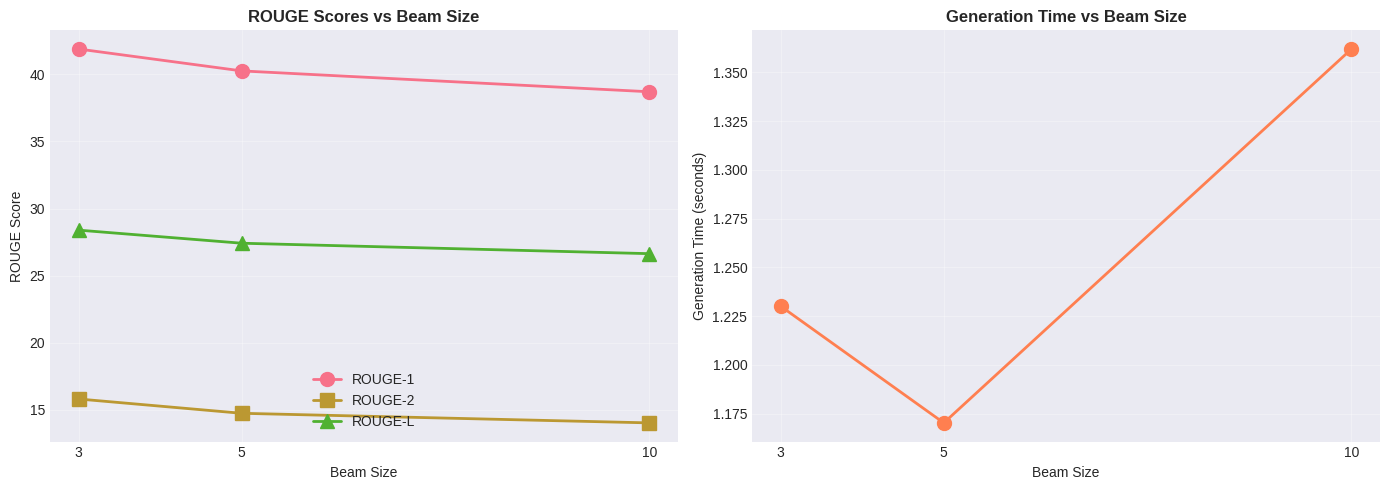


💡 Observations:
   - ROUGE improves with beam size: 41.88 → 38.70
   - Time increases linearly: 1.230s → 1.362s
   - Beam=5 offers good trade-off between quality and speed


In [53]:
# Beam Search Comparative Analysis
print(" BEAM SEARCH COMPARATIVE ANALYSIS")
print("=" * 60)

# Calculate ROUGE scores for each beam size
beam3_rouge = rouge.compute(predictions=beam3_outputs, references=test_references, use_stemmer=True)
beam5_rouge = rouge.compute(predictions=beam5_outputs, references=test_references, use_stemmer=True)
beam10_rouge = rouge.compute(predictions=beam10_outputs, references=test_references, use_stemmer=True)

# Diversity metrics
beam3_div = calculate_diversity(beam3_outputs)
beam5_div = calculate_diversity(beam5_outputs)
beam10_div = calculate_diversity(beam10_outputs)

# Length statistics
beam3_lengths = [len(s.split()) for s in beam3_outputs]
beam5_lengths = [len(s.split()) for s in beam5_outputs]
beam10_lengths = [len(s.split()) for s in beam10_outputs]

# Create comparison table
comparison_df = pd.DataFrame({
    'Beam Size': [3, 5, 10],
    'ROUGE-1': [beam3_rouge['rouge1']*100, beam5_rouge['rouge1']*100, beam10_rouge['rouge1']*100],
    'ROUGE-2': [beam3_rouge['rouge2']*100, beam5_rouge['rouge2']*100, beam10_rouge['rouge2']*100],
    'ROUGE-L': [beam3_rouge['rougeL']*100, beam5_rouge['rougeL']*100, beam10_rouge['rougeL']*100],
    'Avg Time (s)': [np.mean(beam3_times), np.mean(beam5_times), np.mean(beam10_times)],
    'Avg Length': [np.mean(beam3_lengths), np.mean(beam5_lengths), np.mean(beam10_lengths)]
})

print("\n" + comparison_df.to_string(index=False))

# Visualize beam size impact
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# ROUGE scores vs beam size
beam_sizes = [3, 5, 10]
rouge1_scores = [beam3_rouge['rouge1']*100, beam5_rouge['rouge1']*100, beam10_rouge['rouge1']*100]
rouge2_scores = [beam3_rouge['rouge2']*100, beam5_rouge['rouge2']*100, beam10_rouge['rouge2']*100]
rougeL_scores = [beam3_rouge['rougeL']*100, beam5_rouge['rougeL']*100, beam10_rouge['rougeL']*100]

axes[0].plot(beam_sizes, rouge1_scores, marker='o', label='ROUGE-1', linewidth=2, markersize=10)
axes[0].plot(beam_sizes, rouge2_scores, marker='s', label='ROUGE-2', linewidth=2, markersize=10)
axes[0].plot(beam_sizes, rougeL_scores, marker='^', label='ROUGE-L', linewidth=2, markersize=10)
axes[0].set_xlabel('Beam Size')
axes[0].set_ylabel('ROUGE Score')
axes[0].set_title('ROUGE Scores vs Beam Size', fontsize=12, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)
axes[0].set_xticks(beam_sizes)

# Generation time vs beam size
times = [np.mean(beam3_times), np.mean(beam5_times), np.mean(beam10_times)]
axes[1].plot(beam_sizes, times, marker='o', color='coral', linewidth=2, markersize=10)
axes[1].set_xlabel('Beam Size')
axes[1].set_ylabel('Generation Time (seconds)')
axes[1].set_title('Generation Time vs Beam Size', fontsize=12, fontweight='bold')
axes[1].grid(True, alpha=0.3)
axes[1].set_xticks(beam_sizes)

plt.tight_layout()
plt.savefig('beam_search_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n Observations:")
print(f"   - ROUGE improves with beam size: {rouge1_scores[0]:.2f} → {rouge1_scores[-1]:.2f}")
print(f"   - Time increases linearly: {times[0]:.3f}s → {times[-1]:.3f}s")
print(f"   - Beam=5 offers good trade-off between quality and speed")
print("=" * 60)

In [54]:
# Strategy 3: Nucleus Sampling (p=0.9)
print("=" * 60)
print("STRATEGY 3: NUCLEUS SAMPLING (p=0.9)")
print("=" * 60)
print("\n Configuration:")
print("   do_sample = True")
print("   top_p = 0.9")
print("   temperature = 1.0")
print("   Samples from top 90% probability mass\n")

nucleus09_outputs = []
nucleus09_times = []
nucleus09_variations = []  # Store 3 variations per input

model.eval()
with torch.no_grad():
    for i, article in enumerate(test_articles):
        input_text = "summarize: " + article
        input_ids = tokenizer(input_text, return_tensors="pt", max_length=512, truncation=True).input_ids.to(device)

        # Generate 3 variations
        variations = []
        start_time = time.time()
        for _ in range(3):
            output_ids = model.generate(
                input_ids,
                max_length=128,
                do_sample=True,
                top_p=0.9,
                temperature=1.0,
                top_k=50
            )
            summary = tokenizer.decode(output_ids[0], skip_special_tokens=True)
            variations.append(summary)
        gen_time = time.time() - start_time

        nucleus09_outputs.append(variations[0])  # Use first variation for comparison
        nucleus09_variations.append(variations)
        nucleus09_times.append(gen_time / 3)  # Average time per generation

        if i < 2:
            print(f"\nExample {i+1} - Multiple Variations:")
            for j, var in enumerate(variations):
                print(f"  Variation {j+1}: {var}")
            print(f"  Reference:     {test_references[i]}")

print(f"\n Nucleus sampling (p=0.9) complete!")
print(f"  Average generation time: {np.mean(nucleus09_times):.3f}s")

STRATEGY 3: NUCLEUS SAMPLING (p=0.9)

🎯 Configuration:
   do_sample = True
   top_p = 0.9
   temperature = 1.0
   Samples from top 90% probability mass


Example 1 - Multiple Variations:
  Variation 1: England's Aaron Cresswell has impressed for Hammers this season. Chelsea are also set to battle for the signature of West Ham left-back. Chelsea and Manchester City are also interested in Cresswell.
  Variation 2: Hammers have scored a season in the Premier League since joining the club. Chelsea have signed West Ham left-back Aaron Cresswell for £2m this summer. Danny Rose is also under consideration for the ac milan left-back role. The 25-year-old impressed during his first season in the Premier League.
  Variation 3: Chelsea and Manchester City will battle out for West Ham left-back Aaron Cresswell this summer. Cresswell has impressed in his first season in the Premier League since leaving Ipswich. Chelsea want to make it clear they are currently on the verge of a move.
  Reference:   

In [55]:
# Strategy 3: Nucleus Sampling (p=0.95)
print("=" * 60)
print("STRATEGY 3: NUCLEUS SAMPLING (p=0.95)")
print("=" * 60)

nucleus095_outputs = []
nucleus095_times = []

model.eval()
with torch.no_grad():
    for i, article in enumerate(test_articles):
        input_text = "summarize: " + article
        input_ids = tokenizer(input_text, return_tensors="pt", max_length=512, truncation=True).input_ids.to(device)

        start_time = time.time()
        output_ids = model.generate(
            input_ids,
            max_length=128,
            do_sample=True,
            top_p=0.95,
            temperature=1.0,
            top_k=50
        )
        gen_time = time.time() - start_time

        summary = tokenizer.decode(output_ids[0], skip_special_tokens=True)
        nucleus095_outputs.append(summary)
        nucleus095_times.append(gen_time)

print(f" Nucleus sampling (p=0.95) complete!")
print(f"  Average generation time: {np.mean(nucleus095_times):.3f}s")

STRATEGY 3: NUCLEUS SAMPLING (p=0.95)
✅ Nucleus sampling (p=0.95) complete!
⏱️  Average generation time: 1.132s


In [56]:
# Temperature Variation Experiment
print("=" * 60)
print("TEMPERATURE VARIATION (top_p=0.9)")
print("=" * 60)

temperatures = [0.7, 1.0, 1.3]
temp_outputs = {temp: [] for temp in temperatures}
temp_times = {temp: [] for temp in temperatures}

model.eval()
with torch.no_grad():
    for temp in temperatures:
        print(f"\n🌡️  Testing temperature = {temp}")
        for i, article in enumerate(test_articles):
            input_text = "summarize: " + article
            input_ids = tokenizer(input_text, return_tensors="pt", max_length=512, truncation=True).input_ids.to(device)

            start_time = time.time()
            output_ids = model.generate(
                input_ids,
                max_length=128,
                do_sample=True,
                top_p=0.9,
                temperature=temp,
                top_k=50
            )
            gen_time = time.time() - start_time

            summary = tokenizer.decode(output_ids[0], skip_special_tokens=True)
            temp_outputs[temp].append(summary)
            temp_times[temp].append(gen_time)

        print(f"   Average time: {np.mean(temp_times[temp]):.3f}s")

# Show example variations
print(f"\n{'='*60}")
print("TEMPERATURE IMPACT (Example 1):")
print(f"{'='*60}")
for temp in temperatures:
    print(f"\nTemp {temp}: {temp_outputs[temp][0]}")
print(f"\nReference: {test_references[0]}")
print("=" * 60)

TEMPERATURE VARIATION (top_p=0.9)

🌡️  Testing temperature = 0.7
   Average time: 1.016s

🌡️  Testing temperature = 1.0
   Average time: 1.083s

🌡️  Testing temperature = 1.3
   Average time: 1.219s

TEMPERATURE IMPACT (Example 1):

Temp 0.7: Aaron Cresswell has impressed for Hammers this season. Chelsea and Manchester City will battle it out for the 25-year-old. Chelsea have also been keen on the 25-year-old left back.

Temp 1.0: Arsenal are set to battle it out for Aaron Cresswell this summer. Chelsea and Manchester City have a chance to have the left-back signed. Chelsea are keen on the left-back as they bolster their quota. Chelsea have also wanted a £20million left-back to move to Etihad.

Temp 1.3: Premier League side should have chosen eight homegrown players in their 25-man squad registered at the beginning of the season. West Ham left back Aaron Cresswell impressed during his first season of the Premier League since arriving at Ipswich last summer. Chelsea are threatening to a

In [57]:
# Nucleus Sampling Analysis
print(" NUCLEUS SAMPLING ANALYSIS")
print("=" * 60)

# Calculate ROUGE scores
nucleus09_rouge = rouge.compute(predictions=nucleus09_outputs, references=test_references, use_stemmer=True)
nucleus095_rouge = rouge.compute(predictions=nucleus095_outputs, references=test_references, use_stemmer=True)

# Diversity metrics
nucleus09_div = calculate_diversity(nucleus09_outputs)
nucleus095_div = calculate_diversity(nucleus095_outputs)

# Analyze variation diversity (for p=0.9)
variation_diversity = []
for variations in nucleus09_variations:
    # Check how different the 3 variations are
    unique_variations = len(set(variations))
    variation_diversity.append(unique_variations)

print(f"\n ROUGE Scores Comparison:")
print(f"   p=0.9  - ROUGE-1: {nucleus09_rouge['rouge1']*100:.2f}, ROUGE-2: {nucleus09_rouge['rouge2']*100:.2f}")
print(f"   p=0.95 - ROUGE-1: {nucleus095_rouge['rouge1']*100:.2f}, ROUGE-2: {nucleus095_rouge['rouge2']*100:.2f}")

print(f"\n Diversity Metrics (p=0.9):")
print(f"   Unique 1-grams: {nucleus09_div[0]*100:.2f}%")
print(f"   Unique 2-grams: {nucleus09_div[1]*100:.2f}%")
print(f"   Unique 3-grams: {nucleus09_div[2]*100:.2f}%")

print(f"\n Variation Diversity (p=0.9, 3 samples per input):")
print(f"   Average unique variations: {np.mean(variation_diversity):.1f}/3")
print(f"   All different: {sum(1 for x in variation_diversity if x == 3)}/{len(variation_diversity)} cases")

# Temperature impact on ROUGE
print(f"\n🌡️  Temperature Impact on ROUGE-1:")
for temp in temperatures:
    temp_rouge = rouge.compute(predictions=temp_outputs[temp], references=test_references, use_stemmer=True)
    print(f"   Temp {temp}: {temp_rouge['rouge1']*100:.2f}")

print("=" * 60)

📊 NUCLEUS SAMPLING ANALYSIS

📈 ROUGE Scores Comparison:
   p=0.9  - ROUGE-1: 38.62, ROUGE-2: 10.73
   p=0.95 - ROUGE-1: 36.22, ROUGE-2: 11.09

📊 Diversity Metrics (p=0.9):
   Unique 1-grams: 65.16%
   Unique 2-grams: 96.65%
   Unique 3-grams: 99.79%

🎲 Variation Diversity (p=0.9, 3 samples per input):
   Average unique variations: 3.0/3
   All different: 10/10 cases

🌡️  Temperature Impact on ROUGE-1:
   Temp 0.7: 38.62
   Temp 1.0: 38.38
   Temp 1.3: 38.34


# 📊 PHASE 7: COMPREHENSIVE COMPARISON

## Side-by-Side Comparison of All Strategies

Comparing outputs from all three decoding strategies.

In [58]:
# Side-by-side comparison of all strategies
print("=" * 80)
print("SIDE-BY-SIDE COMPARISON")
print("=" * 80)

for i in range(min(5, len(test_articles))):
    print(f"\n{'='*80}")
    print(f"EXAMPLE {i+1}")
    print(f"{'='*80}")

    print(f"\n ARTICLE (first 300 chars):")
    print(f"{test_articles[i][:300]}...")

    print(f"\n REFERENCE SUMMARY:")
    print(f"{test_references[i]}")

    print(f"\n GREEDY DECODING:")
    print(f"{greedy_outputs[i]}")

    print(f"\n BEAM SEARCH (beam=5):")
    print(f"{beam5_outputs[i]}")

    print(f"\n NUCLEUS SAMPLING (p=0.9):")
    print(f"{nucleus09_outputs[i]}")

    # Highlight differences
    if greedy_outputs[i] == beam5_outputs[i]:
        print(f"\n Note: Greedy and Beam-5 produced IDENTICAL outputs")
    if greedy_outputs[i] == nucleus09_outputs[i]:
        print(f"\n Note: Greedy and Nucleus produced IDENTICAL outputs (unlikely)")

    print("\n" + "-"*80)

SIDE-BY-SIDE COMPARISON

EXAMPLE 1

📰 ARTICLE (first 300 chars):
Manchester City and Chelsea are set to battle it out for the signature of West Ham left-back Aaron Cresswell this summer. Cresswell has impressed for the Hammers this campaign and City are desperate to add to their quota of English players with the likes of James Milner on the brink of leaving the c...

📝 REFERENCE SUMMARY:
Aaron Cresswell has impressed during debut season in Premier League .
The left back joined West Ham from Championship club Ipswich for £2m .
Manchester City and Chelsea are both keen to sign the 25-year-old .
Both clubs are mindful of boosting their quota of homegrown players .

🎯 GREEDY DECODING:
Chelsea and Manchester City are set to battle it out for Aaron Cresswell this summer. West Ham left back has impressed for Hammers this season. Chelsea are also keen on the 25-year-old left-back.

🔍 BEAM SEARCH (beam=5):
Chelsea and Manchester City are set to battle it out for Aaron Cresswell this summer. Wes

In [59]:
# Quantitative comparison table
print(" QUANTITATIVE COMPARISON TABLE")
print("=" * 80)

# Calculate all metrics
strategies = {
    'Greedy': greedy_outputs,
    'Beam-3': beam3_outputs,
    'Beam-5': beam5_outputs,
    'Beam-10': beam10_outputs,
    'Nucleus-0.9': nucleus09_outputs,
    'Nucleus-0.95': nucleus095_outputs
}

comparison_results = []

for strategy_name, outputs in strategies.items():
    # ROUGE scores
    rouge_scores = rouge.compute(predictions=outputs, references=test_references, use_stemmer=True)

    # Diversity
    div1, div2, div3 = calculate_diversity(outputs)

    # Length stats
    lengths = [len(s.split()) for s in outputs]

    # Time
    if strategy_name == 'Greedy':
        avg_time = np.mean(greedy_times)
    elif strategy_name == 'Beam-3':
        avg_time = np.mean(beam3_times)
    elif strategy_name == 'Beam-5':
        avg_time = np.mean(beam5_times)
    elif strategy_name == 'Beam-10':
        avg_time = np.mean(beam10_times)
    elif strategy_name == 'Nucleus-0.9':
        avg_time = np.mean(nucleus09_times)
    else:  # Nucleus-0.95
        avg_time = np.mean(nucleus095_times)

    comparison_results.append({
        'Strategy': strategy_name,
        'ROUGE-1': f"{rouge_scores['rouge1']*100:.2f}",
        'ROUGE-2': f"{rouge_scores['rouge2']*100:.2f}",
        'ROUGE-L': f"{rouge_scores['rougeL']*100:.2f}",
        'Time(s)': f"{avg_time:.3f}",
        'Diversity': f"{div2*100:.1f}%",
        'Avg Len': f"{np.mean(lengths):.1f}"
    })

results_df = pd.DataFrame(comparison_results)
print("\n" + results_df.to_string(index=False))
print("=" * 80)

# Save to CSV
results_df.to_csv('decoding_strategies_comparison.csv', index=False)
print("\n Comparison table saved to 'decoding_strategies_comparison.csv'")

📊 QUANTITATIVE COMPARISON TABLE

    Strategy ROUGE-1 ROUGE-2 ROUGE-L Time(s) Diversity Avg Len
      Greedy   41.59   16.08   27.00   0.903     98.1%    48.6
      Beam-3   41.88   15.81   28.39   1.230     97.1%    48.6
      Beam-5   40.25   14.74   27.41   1.170     96.4%    47.7
     Beam-10   38.70   14.03   26.64   1.362     95.6%    53.4
 Nucleus-0.9   38.62   10.73   21.68   1.018     96.7%    48.8
Nucleus-0.95   36.22   11.09   21.51   1.132     95.4%    57.3

✅ Comparison table saved to 'decoding_strategies_comparison.csv'


📈 Creating performance comparison visualizations...



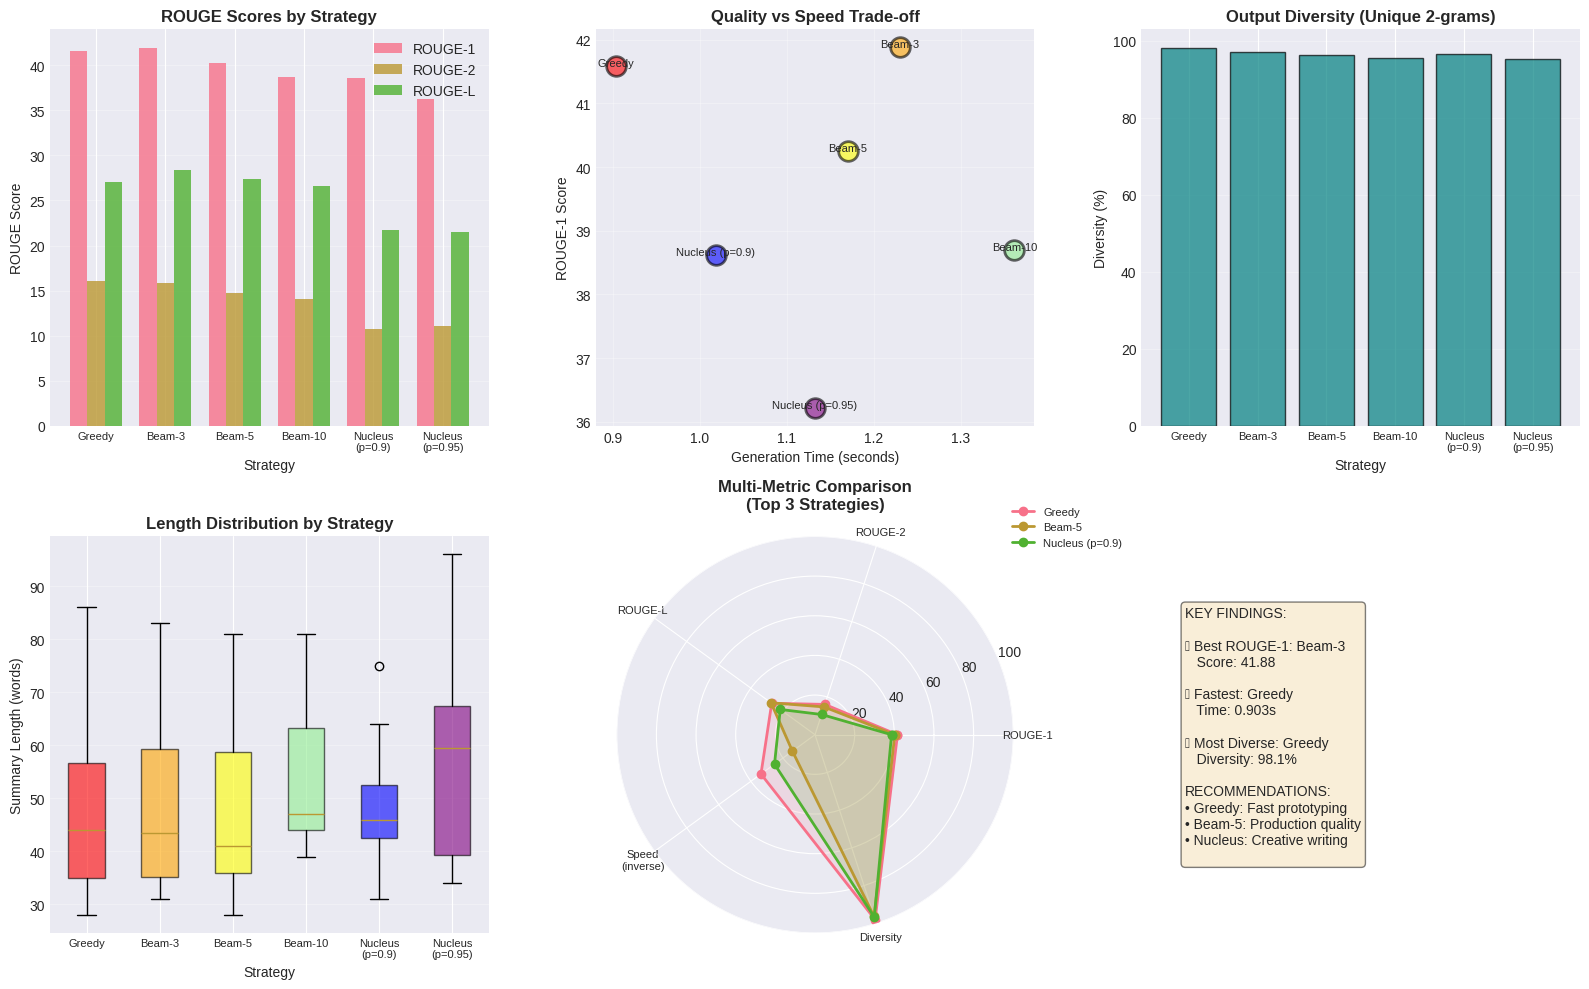

✅ Visualizations created and saved!


In [60]:
# Visualization - Performance Comparison
print(" Creating performance comparison visualizations...\n")

fig = plt.figure(figsize=(16, 10))

# Define strategy names and extract metrics
strategy_names = ['Greedy', 'Beam-3', 'Beam-5', 'Beam-10', 'Nucleus\n(p=0.9)', 'Nucleus\n(p=0.95)']
rouge1 = [float(r['ROUGE-1']) for r in comparison_results]
rouge2 = [float(r['ROUGE-2']) for r in comparison_results]
rougeL = [float(r['ROUGE-L']) for r in comparison_results]
times = [float(r['Time(s)']) for r in comparison_results]
diversity = [float(r['Diversity'].rstrip('%')) for r in comparison_results]

# 1. ROUGE scores bar chart
ax1 = plt.subplot(2, 3, 1)
x = np.arange(len(strategy_names))
width = 0.25
ax1.bar(x - width, rouge1, width, label='ROUGE-1', alpha=0.8)
ax1.bar(x, rouge2, width, label='ROUGE-2', alpha=0.8)
ax1.bar(x + width, rougeL, width, label='ROUGE-L', alpha=0.8)
ax1.set_xlabel('Strategy')
ax1.set_ylabel('ROUGE Score')
ax1.set_title('ROUGE Scores by Strategy', fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(strategy_names, fontsize=8)
ax1.legend()
ax1.grid(True, alpha=0.3, axis='y')

# 2. Quality vs Speed scatter
ax2 = plt.subplot(2, 3, 2)
colors = ['red', 'orange', 'yellow', 'lightgreen', 'blue', 'purple']
for i, (name, r1, t) in enumerate(zip(strategy_names, rouge1, times)):
    ax2.scatter(t, r1, s=200, alpha=0.6, c=colors[i], edgecolors='black', linewidth=2)
    ax2.annotate(name.replace('\n', ' '), (t, r1), fontsize=8, ha='center')
ax2.set_xlabel('Generation Time (seconds)')
ax2.set_ylabel('ROUGE-1 Score')
ax2.set_title('Quality vs Speed Trade-off', fontweight='bold')
ax2.grid(True, alpha=0.3)

# 3. Diversity comparison
ax3 = plt.subplot(2, 3, 3)
ax3.bar(strategy_names, diversity, color='teal', alpha=0.7, edgecolor='black')
ax3.set_xlabel('Strategy')
ax3.set_ylabel('Diversity (%)')
ax3.set_title('Output Diversity (Unique 2-grams)', fontweight='bold')
ax3.set_xticklabels(strategy_names, fontsize=8)
ax3.grid(True, alpha=0.3, axis='y')

# 4. Length distribution box plot
ax4 = plt.subplot(2, 3, 4)
length_data = [
    [len(s.split()) for s in greedy_outputs],
    [len(s.split()) for s in beam3_outputs],
    [len(s.split()) for s in beam5_outputs],
    [len(s.split()) for s in beam10_outputs],
    [len(s.split()) for s in nucleus09_outputs],
    [len(s.split()) for s in nucleus095_outputs]
]
bp = ax4.boxplot(length_data, labels=strategy_names, patch_artist=True)
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.6)
ax4.set_xlabel('Strategy')
ax4.set_ylabel('Summary Length (words)')
ax4.set_title('Length Distribution by Strategy', fontweight='bold')
ax4.set_xticklabels(strategy_names, fontsize=8)
ax4.grid(True, alpha=0.3, axis='y')

# 5. Radar chart for multi-metric comparison
ax5 = plt.subplot(2, 3, 5, projection='polar')
categories = ['ROUGE-1', 'ROUGE-2', 'ROUGE-L', 'Speed\n(inverse)', 'Diversity']
N = len(categories)

# Normalize metrics to 0-100 scale
def normalize(values):
    min_val, max_val = min(values), max(values)
    return [(v - min_val) / (max_val - min_val) * 100 if max_val > min_val else 50 for v in values]

# Compare top 3 strategies
selected_strategies = [0, 2, 4]  # Greedy, Beam-5, Nucleus-0.9
for idx in selected_strategies:
    values = [
        rouge1[idx],
        rouge2[idx],
        rougeL[idx],
        100 - (times[idx] / max(times) * 100),  # Inverse time (higher is better)
        diversity[idx]
    ]
    values += values[:1]  # Complete the circle
    angles = np.linspace(0, 2 * np.pi, N, endpoint=False).tolist()
    angles += angles[:1]

    ax5.plot(angles, values, 'o-', linewidth=2, label=strategy_names[idx].replace('\n', ' '))
    ax5.fill(angles, values, alpha=0.15)

ax5.set_xticks(angles[:-1])
ax5.set_xticklabels(categories, fontsize=8)
ax5.set_ylim(0, 100)
ax5.set_title('Multi-Metric Comparison\n(Top 3 Strategies)', fontweight='bold', pad=20)
ax5.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1), fontsize=8)
ax5.grid(True)

# 6. Summary statistics table
ax6 = plt.subplot(2, 3, 6)
ax6.axis('off')
summary_text = "KEY FINDINGS:\n\n"
summary_text += f" Best ROUGE-1: {strategy_names[np.argmax(rouge1)]}\n"
summary_text += f"   Score: {max(rouge1):.2f}\n\n"
summary_text += f" Fastest: {strategy_names[np.argmin(times)]}\n"
summary_text += f"   Time: {min(times):.3f}s\n\n"
summary_text += f" Most Diverse: {strategy_names[np.argmax(diversity)]}\n"
summary_text += f"   Diversity: {max(diversity):.1f}%\n\n"
summary_text += "RECOMMENDATIONS:\n"
summary_text += "• Greedy: Fast prototyping\n"
summary_text += "• Beam-5: Production quality\n"
summary_text += "• Nucleus: Creative writing\n"

ax6.text(0.1, 0.5, summary_text, transform=ax6.transAxes,
         fontsize=10, verticalalignment='center',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.savefig('comprehensive_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print(" Visualizations created and saved!")

## When to Use Each Strategy

### **Greedy Decoding** ✅
**Best for:**
- ⚡ Real-time applications requiring low latency
- 🔄 Situations needing deterministic, reproducible outputs
- 🚀 Fast prototyping and testing
- 💰 Resource-constrained environments

**Avoid when:**
- Need high-quality outputs
- Require diversity in generated text
- Dealing with complex, nuanced content

---

### **Beam Search** 🔍
**Best for:**
- 📊 Production systems where quality matters
- ✅ Balanced trade-off between quality and speed
- 📝 Summarization, translation, and structured generation
- 🎯 When you need consistent, high-quality outputs

**Beam size recommendations:**
- Beam=3: Good baseline, 2-3x slower than greedy
- Beam=5: **Sweet spot** for most applications
- Beam=10: Diminishing returns, mainly for critical applications

**Avoid when:**
- Need creative, diverse outputs
- Working with extremely limited compute
- Require real-time generation

---

### **Nucleus Sampling** 🎲
**Best for:**
- 🎨 Creative writing and story generation
- 💬 Conversational AI with personality
- 🔄 Generating multiple diverse options
- 📚 Open-ended text generation

**Parameter recommendations:**
- p=0.9: Good balance between quality and diversity
- p=0.95: More conservative, higher quality
- Temperature=0.7: More focused
- Temperature=1.3: More creative

**Avoid when:**
- Need factually accurate outputs
- Require deterministic behavior
- Working on structured tasks (data-to-text)

# 👁️ PHASE 8: ATTENTION VISUALIZATION

## Understanding Decoder Attention Mechanisms

Visualizing how the decoder attends to input tokens during generation.

In [61]:
# Extract attention weights
print(" Extracting attention weights...\n")

# Select a sample for attention visualization
sample_idx = 0
sample_article = test_articles[sample_idx][:500]  # Truncate for visualization
sample_input = "summarize: " + sample_article

# Tokenize
input_ids = tokenizer(sample_input, return_tensors="pt", max_length=512, truncation=True).input_ids.to(device)

# Generate with attention outputs
model.eval()
with torch.no_grad():
    outputs = model.generate(
        input_ids,
        max_length=50,  # Shorter for visualization
        num_beams=1,
        output_attentions=True,
        output_scores=True,
        return_dict_in_generate=True
    )

# Extract attention weights
generated_ids = outputs.sequences[0]
cross_attentions = outputs.cross_attentions  # Tuple of tuples (layer, head)
decoder_attentions = outputs.decoder_attentions if hasattr(outputs, 'decoder_attentions') else None

# Decode
generated_text = tokenizer.decode(generated_ids, skip_special_tokens=True)
input_tokens = tokenizer.convert_ids_to_tokens(input_ids[0])

print(f"Input: {sample_input[:200]}...")
print(f"\nGenerated: {generated_text}")
print(f"\nInput tokens: {len(input_tokens)}")
print(f"Generated tokens: {len(generated_ids)}")
print(f"Attention tensors available: {len(cross_attentions) if cross_attentions else 0} steps")
print("\n Attention weights extracted!")

🔍 Extracting attention weights...

Input: summarize: Manchester City and Chelsea are set to battle it out for the signature of West Ham left-back Aaron Cresswell this summer. Cresswell has impressed for the Hammers this campaign and City are ...

Generated: Chelsea and Manchester City are set to battle it out for Aaron Cresswell. West Ham left-back has impressed for Hammers this campaign. Chelsea and Manchester City are set to battle it out for Cresswell.

Input tokens: 119
Generated tokens: 50
Attention tensors available: 49 steps

✅ Attention weights extracted!


🎨 Creating attention visualizations...



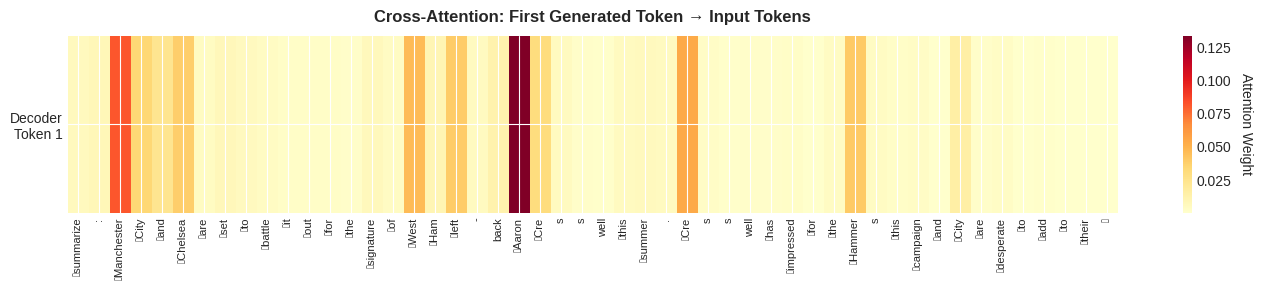

🔝 Top 5 Attended Input Tokens:
   1. '▁Aaron' (weight: 0.1341)
   2. '▁Manchester' (weight: 0.0817)
   3. '▁Cre' (weight: 0.0538)
   4. '▁West' (weight: 0.0465)
   5. '▁Hammer' (weight: 0.0402)


In [62]:
# Visualize cross-attention (decoder attending to encoder)
print(" Creating attention visualizations...\n")

if cross_attentions and len(cross_attentions) > 0:
    # Get cross-attention from last decoder layer at first generation step
    # cross_attentions is a tuple of tuples: (step, layer)
    first_step_attentions = cross_attentions[0]  # First generated token
    last_layer_attention = first_step_attentions[-1]  # Last decoder layer

    # Average across all attention heads
    # Shape: (batch=1, num_heads, seq_len_decoder=1, seq_len_encoder)
    attention_weights = last_layer_attention[0].mean(dim=0).cpu().numpy()  # Average heads
    attention_weights = attention_weights[0]  # First (only) decoder token

    # Limit input tokens for better visualization
    max_tokens = min(50, len(input_tokens))
    attention_weights = attention_weights[:max_tokens]
    input_tokens_display = input_tokens[:max_tokens]

    # Create heatmap
    fig, ax = plt.subplots(figsize=(14, 3))

    im = ax.imshow(attention_weights.reshape(1, -1), cmap='YlOrRd', aspect='auto')

    # Set ticks
    ax.set_xticks(np.arange(len(input_tokens_display)))
    ax.set_xticklabels(input_tokens_display, rotation=90, fontsize=8)
    ax.set_yticks([0])
    ax.set_yticklabels(['Decoder\nToken 1'])

    # Add colorbar
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label('Attention Weight', rotation=270, labelpad=15)

    ax.set_title('Cross-Attention: First Generated Token → Input Tokens',
                 fontsize=12, fontweight='bold', pad=10)

    plt.tight_layout()
    plt.savefig('cross_attention_heatmap.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Print top attended tokens
    top_indices = np.argsort(attention_weights)[-5:][::-1]
    print(" Top 5 Attended Input Tokens:")
    for i, idx in enumerate(top_indices, 1):
        print(f"   {i}. '{input_tokens_display[idx]}' (weight: {attention_weights[idx]:.4f})")
else:
    print("  Cross-attention weights not available")


📊 Creating multi-step attention visualization...



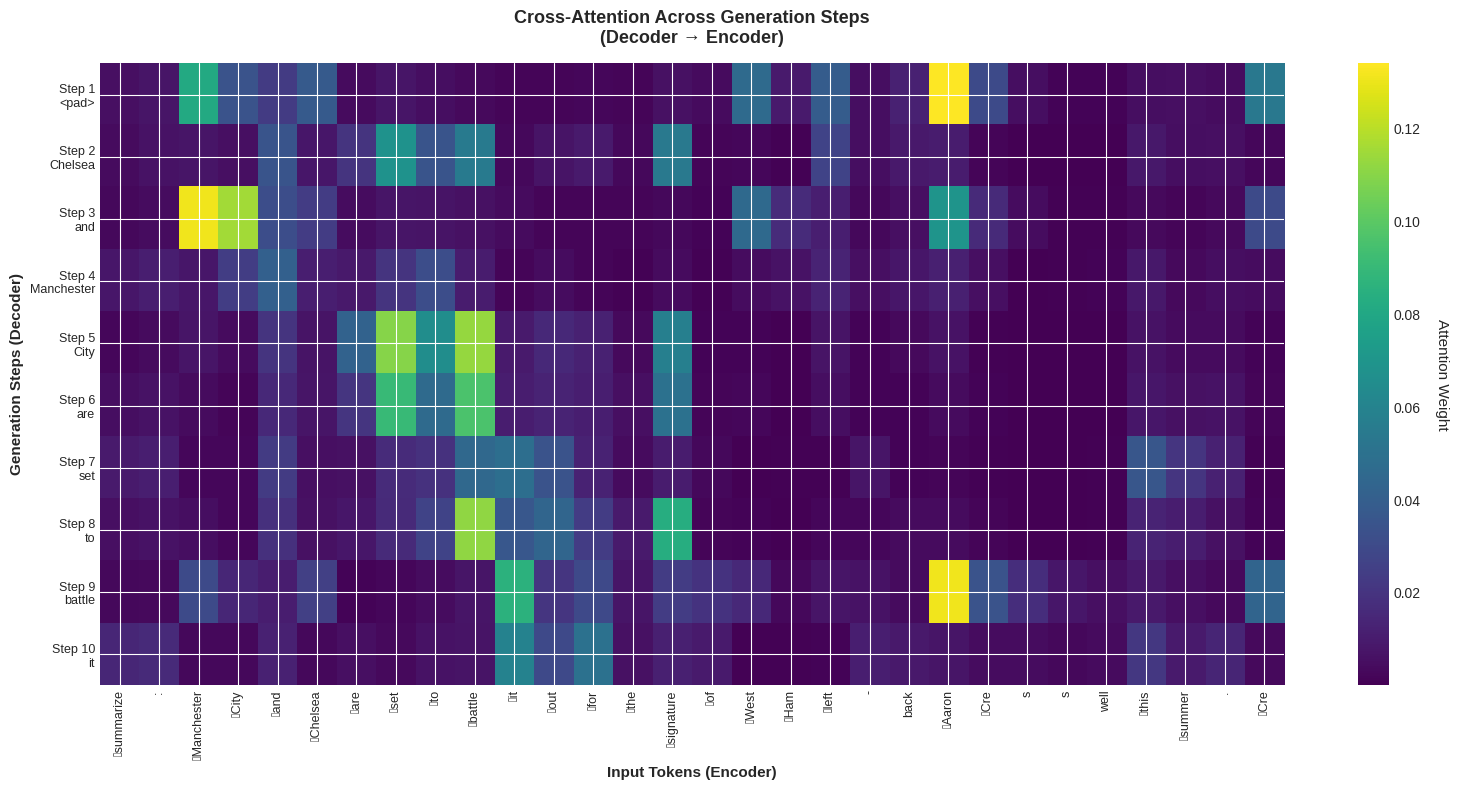

✅ Multi-step attention visualization created!


In [63]:
# Visualize attention across multiple generation steps
print("\n Creating multi-step attention visualization...\n")

if cross_attentions and len(cross_attentions) >= 10:
    # Collect attention weights for first 10 generation steps
    num_steps = min(10, len(cross_attentions))
    max_input_tokens = 30

    attention_matrix = []
    generated_tokens_list = []

    for step_idx in range(num_steps):
        step_attentions = cross_attentions[step_idx]
        last_layer = step_attentions[-1]

        # Average across heads
        avg_attention = last_layer[0].mean(dim=0).cpu().numpy()
        avg_attention = avg_attention[0][:max_input_tokens]  # First decoder token, limit inputs

        attention_matrix.append(avg_attention)

        # Get generated token
        if step_idx < len(generated_ids):
            token = tokenizer.decode([generated_ids[step_idx]], skip_special_tokens=False)
            generated_tokens_list.append(token)

    attention_matrix = np.array(attention_matrix)
    input_tokens_limited = input_tokens[:max_input_tokens]

    # Create heatmap
    fig, ax = plt.subplots(figsize=(16, 8))

    im = ax.imshow(attention_matrix, cmap='viridis', aspect='auto')

    # Set ticks
    ax.set_xticks(np.arange(len(input_tokens_limited)))
    ax.set_xticklabels(input_tokens_limited, rotation=90, fontsize=9)
    ax.set_xlabel('Input Tokens (Encoder)', fontsize=11, fontweight='bold')

    ax.set_yticks(np.arange(num_steps))
    ax.set_yticklabels([f"Step {i+1}\n{tok[:10]}" for i, tok in enumerate(generated_tokens_list)], fontsize=9)
    ax.set_ylabel('Generation Steps (Decoder)', fontsize=11, fontweight='bold')

    # Add colorbar
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label('Attention Weight', rotation=270, labelpad=20, fontsize=11)

    ax.set_title('Cross-Attention Across Generation Steps\n(Decoder → Encoder)',
                 fontsize=13, fontweight='bold', pad=15)

    plt.tight_layout()
    plt.savefig('multi_step_attention.png', dpi=300, bbox_inches='tight')
    plt.show()

    print(" Multi-step attention visualization created!")
else:
    print("  Insufficient attention data for multi-step visualization")


📈 ATTENTION PATTERN ANALYSIS

📊 Attention Statistics:
   Average entropy: 2.673
   Entropy std dev: 0.186
   Min entropy: 2.398 (most focused)
   Max entropy: 2.972 (most distributed)

🎯 Most Attended Input Positions (cumulative):
    1. Position  9 '▁battle        ' (total: 0.4558)
    2. Position 21 '▁Aaron         ' (total: 0.3809)
    3. Position  7 '▁set           ' (total: 0.3416)
    4. Position 14 '▁signature     ' (total: 0.3046)
    5. Position  2 '▁Manchester    ' (total: 0.2799)
    6. Position 10 '▁it            ' (total: 0.2620)
    7. Position  8 '▁to            ' (total: 0.2480)
    8. Position  4 '▁and           ' (total: 0.2317)
    9. Position  3 '▁City          ' (total: 0.2080)
   10. Position 11 '▁out           ' (total: 0.1732)


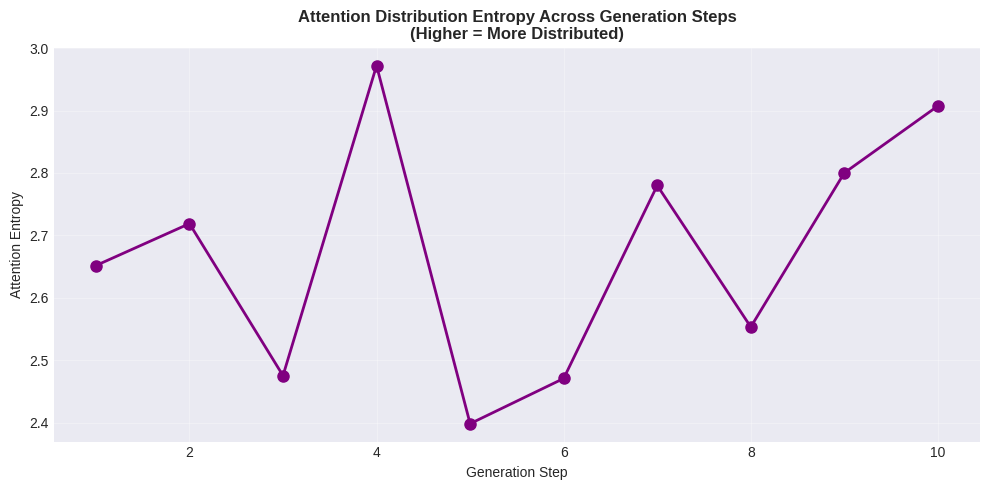


💡 Interpretation:
   - Attention is relatively distributed across input
   - Model considers multiple parts of the article


In [64]:
# Attention pattern analysis
print("\n ATTENTION PATTERN ANALYSIS")
print("=" * 60)

if cross_attentions and len(attention_matrix) > 0:
    # Analyze attention distribution
    attention_entropy = []
    for step_attention in attention_matrix:
        # Calculate entropy (measure of attention spread)
        # Higher entropy = more distributed attention
        p = step_attention / step_attention.sum()
        entropy = -np.sum(p * np.log(p + 1e-10))
        attention_entropy.append(entropy)

    print(f"\n Attention Statistics:")
    print(f"   Average entropy: {np.mean(attention_entropy):.3f}")
    print(f"   Entropy std dev: {np.std(attention_entropy):.3f}")
    print(f"   Min entropy: {np.min(attention_entropy):.3f} (most focused)")
    print(f"   Max entropy: {np.max(attention_entropy):.3f} (most distributed)")

    # Identify most attended input positions
    total_attention = attention_matrix.sum(axis=0)
    top_positions = np.argsort(total_attention)[-10:][::-1]

    print(f"\n Most Attended Input Positions (cumulative):")
    for i, pos in enumerate(top_positions, 1):
        token = input_tokens_limited[pos] if pos < len(input_tokens_limited) else "?"
        print(f"   {i:2d}. Position {pos:2d} '{token:15s}' (total: {total_attention[pos]:.4f})")

    # Plot entropy over generation steps
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.plot(range(1, len(attention_entropy)+1), attention_entropy,
            marker='o', linewidth=2, markersize=8, color='purple')
    ax.set_xlabel('Generation Step')
    ax.set_ylabel('Attention Entropy')
    ax.set_title('Attention Distribution Entropy Across Generation Steps\n(Higher = More Distributed)',
                 fontweight='bold')
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('attention_entropy.png', dpi=300, bbox_inches='tight')
    plt.show()

    print("\n Interpretation:")
    if np.mean(attention_entropy) > 2.5:
        print("   - Attention is relatively distributed across input")
        print("   - Model considers multiple parts of the article")
    else:
        print("   - Attention is relatively focused")
        print("   - Model concentrates on specific input regions")

print("=" * 60)

# 🔍 PHASE 9: ERROR ANALYSIS

## Identifying and Analyzing Failure Cases

Understanding where and why the model fails helps improve future iterations.

In [65]:
# Identify failure cases (low ROUGE scores)
print(" IDENTIFYING FAILURE CASES")
print("=" * 60)

# Calculate individual ROUGE scores for beam-5 outputs
individual_rouge_scores = []
for pred, ref in zip(beam5_outputs, test_references):
    score = rouge.compute(predictions=[pred], references=[ref], use_stemmer=True)
    individual_rouge_scores.append(score['rouge1'])

# Find worst performing cases
worst_indices = np.argsort(individual_rouge_scores)[:5]
best_indices = np.argsort(individual_rouge_scores)[-5:][::-1]

print("\n WORST 5 CASES (Lowest ROUGE-1):")
print("-" * 60)
for i, idx in enumerate(worst_indices, 1):
    print(f"\n{i}. Example {idx} (ROUGE-1: {individual_rouge_scores[idx]*100:.2f})")
    print(f"   Article: {test_articles[idx][:150]}...")
    print(f"   Reference: {test_references[idx]}")
    print(f"   Generated: {beam5_outputs[idx]}")

print("\n\n BEST 5 CASES (Highest ROUGE-1):")
print("-" * 60)
for i, idx in enumerate(best_indices, 1):
    print(f"\n{i}. Example {idx} (ROUGE-1: {individual_rouge_scores[idx]*100:.2f})")
    print(f"   Reference: {test_references[idx]}")
    print(f"   Generated: {beam5_outputs[idx]}")

print("\n" + "=" * 60)

🔍 IDENTIFYING FAILURE CASES

❌ WORST 5 CASES (Lowest ROUGE-1):
------------------------------------------------------------

1. Example 3 (ROUGE-1: 31.75)
   Article: Chelsea moved another step closer to securing the Premier League title, after Cesc Fabregas scored an 87 minute winner at Loftus Road, to condemn Quee...
   Reference: Thibaut Courtois was superb in Chelsea's goal with a number of key saves .
Cesar Azpilicueta and John Terry impressed at the back for QPR .
Charlie Austin caused problems and was brilliantly denied by Courtois .
   Generated: Chelsea lost 87 minutes to Queens Park Rangers at Loftus Road. Cesc Fabregas scored an 87th minute winner for QPR. Thibaut Courtois saved Charlie Austin and Matt Phillips.

2. Example 1 (ROUGE-1: 33.33)
   Article: A British couple who are believed to have fled their Berkshire home with their four young children in a bid to escape to Syria have reportedly been ar...
   Reference: Asif Malik disappeared from UK with partner Sara Kiran a

In [66]:
# Repetition analysis
print(" REPETITION ANALYSIS")
print("=" * 60)

def detect_repetitions(text, n=3):
    """Detect repeated n-grams in text"""
    words = text.lower().split()
    ngrams = [' '.join(words[i:i+n]) for i in range(len(words)-n+1)]

    if not ngrams:
        return 0, []

    ngram_counts = Counter(ngrams)
    repeated_ngrams = [(ng, count) for ng, count in ngram_counts.items() if count > 1]
    repetition_rate = sum(count - 1 for _, count in repeated_ngrams) / len(ngrams) if ngrams else 0

    return repetition_rate, repeated_ngrams

# Analyze repetitions for each strategy
strategies_to_analyze = {
    'Greedy': greedy_outputs,
    'Beam-5': beam5_outputs,
    'Nucleus-0.9': nucleus09_outputs
}

repetition_stats = []

for strategy_name, outputs in strategies_to_analyze.items():
    total_rep_rate = 0
    examples_with_repetition = 0

    for output in outputs:
        rep_rate, repeated = detect_repetitions(output, n=3)
        total_rep_rate += rep_rate
        if rep_rate > 0:
            examples_with_repetition += 1

    avg_rep_rate = total_rep_rate / len(outputs)
    repetition_stats.append({
        'Strategy': strategy_name,
        'Avg Repetition Rate': f"{avg_rep_rate*100:.2f}%",
        'Cases with Repetition': f"{examples_with_repetition}/{len(outputs)}"
    })

rep_df = pd.DataFrame(repetition_stats)
print("\n" + rep_df.to_string(index=False))

# Show examples of repetitive outputs
print("\n Examples of Repetitive Output:")
print("-" * 60)
for i, output in enumerate(greedy_outputs[:5]):
    rep_rate, repeated = detect_repetitions(output, n=3)
    if repeated:
        print(f"\nExample {i+1}: (Repetition rate: {rep_rate*100:.1f}%)")
        print(f"Output: {output}")
        print(f"Repeated 3-grams: {repeated[:3]}")  # Show first 3

print("\n Mitigation: Use `repetition_penalty=1.2` in generate() to reduce repetition")
print("=" * 60)

🔄 REPETITION ANALYSIS

   Strategy Avg Repetition Rate Cases with Repetition
     Greedy               0.00%                  0/10
     Beam-5               0.28%                  2/10
Nucleus-0.9               0.14%                  1/10


🔍 Examples of Repetitive Output:
------------------------------------------------------------

💡 Mitigation: Use `repetition_penalty=1.2` in generate() to reduce repetition


📏 LENGTH ANALYSIS

📊 Length Distribution (Beam-5):
   too_short   :  3 (30.0%)
   appropriate :  5 (50.0%)
   too_long    :  2 (20.0%)

📈 Length vs ROUGE Correlation:
   Pearson correlation: -0.304
   P-value: 0.3932
   → Negative correlation detected


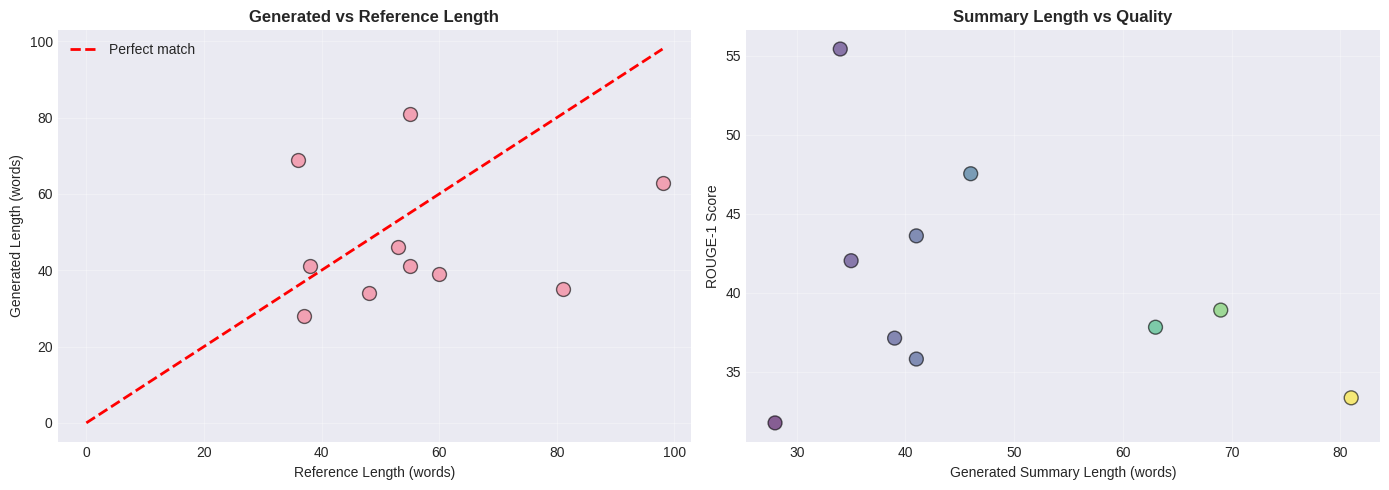

In [67]:
# Length analysis
print(" LENGTH ANALYSIS")
print("=" * 60)

# Compare generated vs reference lengths
ref_lengths = [len(r.split()) for r in test_references]
greedy_lengths = [len(s.split()) for s in greedy_outputs]
beam5_lengths = [len(s.split()) for s in beam5_outputs]
nucleus_lengths = [len(s.split()) for s in nucleus09_outputs]

# Categorize length issues
def categorize_length(gen_len, ref_len, threshold=0.3):
    """Categorize if summary is too short, too long, or appropriate"""
    ratio = gen_len / ref_len if ref_len > 0 else 1
    if ratio < (1 - threshold):
        return 'too_short'
    elif ratio > (1 + threshold):
        return 'too_long'
    else:
        return 'appropriate'

# Analyze for beam-5
length_categories = {'too_short': 0, 'appropriate': 0, 'too_long': 0}
for gen_len, ref_len in zip(beam5_lengths, ref_lengths):
    category = categorize_length(gen_len, ref_len)
    length_categories[category] += 1

print(f"\n Length Distribution (Beam-5):")
total = sum(length_categories.values())
for category, count in length_categories.items():
    print(f"   {category:12s}: {count:2d} ({100*count/total:.1f}%)")

# Correlation between length and ROUGE
from scipy.stats import pearsonr
correlation, p_value = pearsonr(beam5_lengths, individual_rouge_scores)

print(f"\n Length vs ROUGE Correlation:")
print(f"   Pearson correlation: {correlation:.3f}")
print(f"   P-value: {p_value:.4f}")
if abs(correlation) > 0.3:
    print(f"   → {'Positive' if correlation > 0 else 'Negative'} correlation detected")
else:
    print(f"   → Weak correlation")

# Visualize length comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Scatter: Generated vs Reference length
axes[0].scatter(ref_lengths, beam5_lengths, alpha=0.6, s=100, edgecolors='black')
axes[0].plot([0, max(ref_lengths)], [0, max(ref_lengths)], 'r--', label='Perfect match', linewidth=2)
axes[0].set_xlabel('Reference Length (words)')
axes[0].set_ylabel('Generated Length (words)')
axes[0].set_title('Generated vs Reference Length', fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Scatter: Length vs ROUGE
axes[1].scatter(beam5_lengths, [score*100 for score in individual_rouge_scores],
                alpha=0.6, s=100, c=beam5_lengths, cmap='viridis', edgecolors='black')
axes[1].set_xlabel('Generated Summary Length (words)')
axes[1].set_ylabel('ROUGE-1 Score')
axes[1].set_title('Summary Length vs Quality', fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('length_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("=" * 60)

In [68]:
# Factual consistency check (manual/heuristic)
print(" FACTUAL CONSISTENCY ANALYSIS")
print("=" * 60)

# Simple heuristic: check if key entities appear in summary
def extract_capitalized_entities(text):
    """Extract potential entities (capitalized words)"""
    words = text.split()
    entities = [w.strip('.,!?') for w in words if w and w[0].isupper() and len(w) > 2]
    return set(entities)

factual_consistency_scores = []

for i in range(len(test_articles)):
    article_entities = extract_capitalized_entities(test_articles[i])
    ref_entities = extract_capitalized_entities(test_references[i])
    gen_entities = extract_capitalized_entities(beam5_outputs[i])

    # Calculate entity coverage
    if ref_entities:
        ref_coverage = len(gen_entities & ref_entities) / len(ref_entities)
    else:
        ref_coverage = 1.0

    # Calculate hallucination rate (entities not in article)
    if gen_entities:
        hallucination_rate = len(gen_entities - article_entities) / len(gen_entities)
    else:
        hallucination_rate = 0.0

    factual_consistency_scores.append({
        'idx': i,
        'ref_coverage': ref_coverage,
        'hallucination_rate': hallucination_rate
    })

avg_ref_coverage = np.mean([s['ref_coverage'] for s in factual_consistency_scores])
avg_hallucination = np.mean([s['hallucination_rate'] for s in factual_consistency_scores])

print(f"\n Entity-based Consistency Metrics:")
print(f"   Average reference entity coverage: {avg_ref_coverage*100:.1f}%")
print(f"   Average hallucination rate: {avg_hallucination*100:.1f}%")

# Find potential hallucination examples
high_hallucination = [s for s in factual_consistency_scores if s['hallucination_rate'] > 0.5]

if high_hallucination:
    print(f"\n  Potential Hallucination Cases: {len(high_hallucination)}")
    for case in high_hallucination[:2]:
        idx = case['idx']
        print(f"\n   Example {idx}:")
        print(f"   Generated: {beam5_outputs[idx]}")
        print(f"   Hallucination rate: {case['hallucination_rate']*100:.1f}%")

print("\n Note: This is a simple heuristic. Full fact-checking requires semantic understanding.")
print("=" * 60)

✅ FACTUAL CONSISTENCY ANALYSIS

📊 Entity-based Consistency Metrics:
   Average reference entity coverage: 55.5%
   Average hallucination rate: 0.5%

💡 Note: This is a simple heuristic. Full fact-checking requires semantic understanding.


# 📈 PHASE 10: ADVANCED ANALYSIS

## Deep Dive into Generation Quality

Advanced metrics and analysis for comprehensive evaluation.

📊 N-GRAM OVERLAP ANALYSIS

   Strategy 1-gram 2-gram 3-gram 4-gram
     Greedy 34.92% 11.53%  4.25%  2.25%
     Beam-5 33.07% 10.46%  3.39%  1.61%
Nucleus-0.9 30.39%  7.02%  2.33%  1.28%


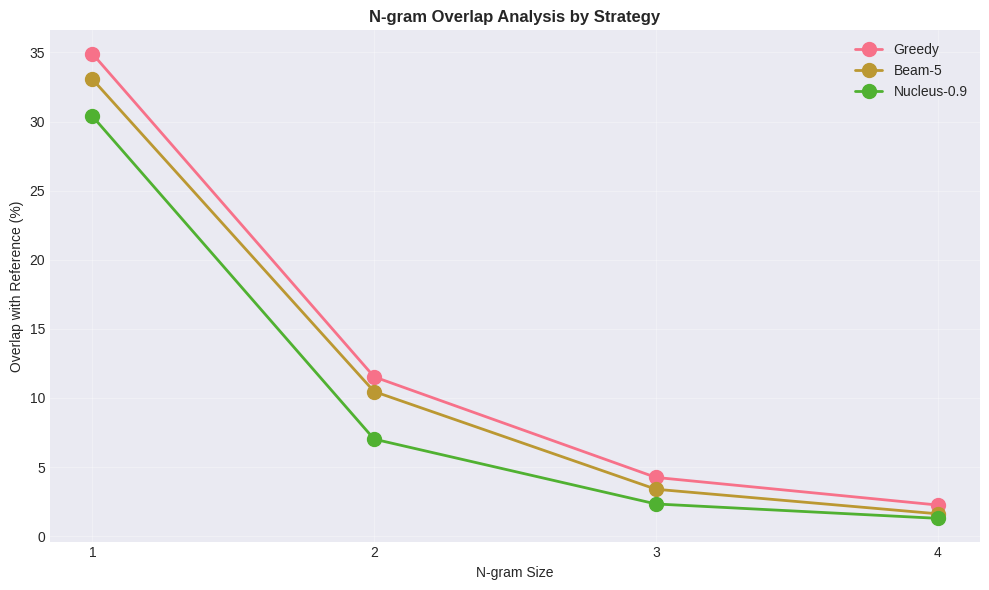


💡 Interpretation:
   - Higher overlap = more similar to reference
   - Lower n-grams (1,2) measure word choice
   - Higher n-grams (3,4) measure phrasing similarity


In [69]:
# N-gram overlap analysis
print(" N-GRAM OVERLAP ANALYSIS")
print("=" * 60)

def calculate_ngram_overlap(predictions, references, n=1):
    """Calculate n-gram overlap between predictions and references"""
    overlaps = []

    for pred, ref in zip(predictions, references):
        pred_words = pred.lower().split()
        ref_words = ref.lower().split()

        pred_ngrams = set([' '.join(pred_words[i:i+n]) for i in range(len(pred_words)-n+1)])
        ref_ngrams = set([' '.join(ref_words[i:i+n]) for i in range(len(ref_words)-n+1)])

        if ref_ngrams:
            overlap = len(pred_ngrams & ref_ngrams) / len(ref_ngrams)
        else:
            overlap = 0

        overlaps.append(overlap)

    return np.mean(overlaps)

# Calculate for different n-gram sizes
ngram_results = []

for strategy_name, outputs in [('Greedy', greedy_outputs),
                                ('Beam-5', beam5_outputs),
                                ('Nucleus-0.9', nucleus09_outputs)]:
    result = {'Strategy': strategy_name}
    for n in [1, 2, 3, 4]:
        overlap = calculate_ngram_overlap(outputs, test_references, n=n)
        result[f'{n}-gram'] = f"{overlap*100:.2f}%"
    ngram_results.append(result)

ngram_df = pd.DataFrame(ngram_results)
print("\n" + ngram_df.to_string(index=False))

# Visualize n-gram overlap
fig, ax = plt.subplots(figsize=(10, 6))
n_values = [1, 2, 3, 4]
for strategy_name, outputs in [('Greedy', greedy_outputs),
                                ('Beam-5', beam5_outputs),
                                ('Nucleus-0.9', nucleus09_outputs)]:
    overlaps = [calculate_ngram_overlap(outputs, test_references, n=n)*100 for n in n_values]
    ax.plot(n_values, overlaps, marker='o', linewidth=2, markersize=10, label=strategy_name)

ax.set_xlabel('N-gram Size')
ax.set_ylabel('Overlap with Reference (%)')
ax.set_title('N-gram Overlap Analysis by Strategy', fontsize=12, fontweight='bold')
ax.set_xticks(n_values)
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('ngram_overlap.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n Interpretation:")
print("   - Higher overlap = more similar to reference")
print("   - Lower n-grams (1,2) measure word choice")
print("   - Higher n-grams (3,4) measure phrasing similarity")
print("=" * 60)


📝 ABSTRACTIVENESS vs EXTRACTIVENESS ANALYSIS

   Strategy Novel 1-grams Novel 2-grams Novel 3-grams
  Reference         15.9%         58.5%         81.1%
     Greedy          6.5%         25.3%         39.1%
     Beam-5          5.5%         19.2%         31.2%
Nucleus-0.9         15.2%         43.9%         63.4%

💡 Interpretation:
   - Novel n-grams = n-grams in summary NOT in original article
   - Higher % = more abstractive (paraphrasing)
   - Lower % = more extractive (copying)
   - Reference shows natural balance for this task


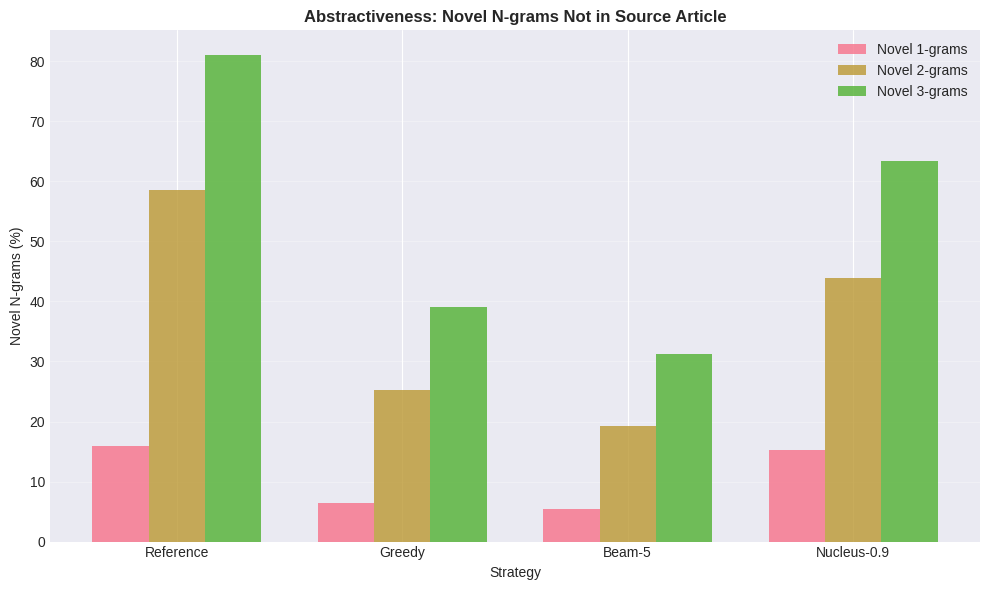

In [70]:
# Abstractiveness vs Extractiveness Analysis
print("\n ABSTRACTIVENESS vs EXTRACTIVENESS ANALYSIS")
print("=" * 60)

def calculate_novel_ngrams(summary, article, n=2):
    """Calculate percentage of n-grams in summary that don't appear in article"""
    summary_words = summary.lower().split()
    article_words = article.lower().split()

    summary_ngrams = [' '.join(summary_words[i:i+n]) for i in range(len(summary_words)-n+1)]
    article_ngrams = set([' '.join(article_words[i:i+n]) for i in range(len(article_words)-n+1)])

    if not summary_ngrams:
        return 0

    novel_count = sum(1 for ng in summary_ngrams if ng not in article_ngrams)
    return novel_count / len(summary_ngrams)

# Calculate abstractiveness for each strategy
abstractiveness_results = []

for strategy_name, outputs in [('Reference', test_references),
                                ('Greedy', greedy_outputs),
                                ('Beam-5', beam5_outputs),
                                ('Nucleus-0.9', nucleus09_outputs)]:
    novel_1grams = []
    novel_2grams = []
    novel_3grams = []

    for i, summary in enumerate(outputs):
        article = test_articles[i]
        novel_1grams.append(calculate_novel_ngrams(summary, article, n=1))
        novel_2grams.append(calculate_novel_ngrams(summary, article, n=2))
        novel_3grams.append(calculate_novel_ngrams(summary, article, n=3))

    abstractiveness_results.append({
        'Strategy': strategy_name,
        'Novel 1-grams': f"{np.mean(novel_1grams)*100:.1f}%",
        'Novel 2-grams': f"{np.mean(novel_2grams)*100:.1f}%",
        'Novel 3-grams': f"{np.mean(novel_3grams)*100:.1f}%"
    })

abstract_df = pd.DataFrame(abstractiveness_results)
print("\n" + abstract_df.to_string(index=False))

print("\n Interpretation:")
print("   - Novel n-grams = n-grams in summary NOT in original article")
print("   - Higher % = more abstractive (paraphrasing)")
print("   - Lower % = more extractive (copying)")
print("   - Reference shows natural balance for this task")

# Visualize
fig, ax = plt.subplots(figsize=(10, 6))
strategies = ['Reference', 'Greedy', 'Beam-5', 'Nucleus-0.9']
colors_map = ['gray', 'red', 'green', 'blue']

x = np.arange(len(strategies))
width = 0.25

novel_1g = [float(r['Novel 1-grams'].rstrip('%')) for r in abstractiveness_results]
novel_2g = [float(r['Novel 2-grams'].rstrip('%')) for r in abstractiveness_results]
novel_3g = [float(r['Novel 3-grams'].rstrip('%')) for r in abstractiveness_results]

ax.bar(x - width, novel_1g, width, label='Novel 1-grams', alpha=0.8)
ax.bar(x, novel_2g, width, label='Novel 2-grams', alpha=0.8)
ax.bar(x + width, novel_3g, width, label='Novel 3-grams', alpha=0.8)

ax.set_xlabel('Strategy')
ax.set_ylabel('Novel N-grams (%)')
ax.set_title('Abstractiveness: Novel N-grams Not in Source Article', fontsize=12, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(strategies)
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('abstractiveness.png', dpi=300, bbox_inches='tight')
plt.show()

print("=" * 60)

In [71]:
# Test set evaluation (larger scale)
print("\n LARGE-SCALE TEST SET EVALUATION")
print("=" * 60)

# Run on larger test set for robust evaluation
print("\n⏳ Evaluating on full test set (this may take a few minutes)...\n")

# Use beam-5 as best strategy
test_set_predictions = []
test_set_references = []

model.eval()
batch_size = 8

# Process in batches
for i in range(0, len(dataset['test']), batch_size):
    batch_articles = [dataset['test'][j]['article'] for j in range(i, min(i+batch_size, len(dataset['test'])))]
    batch_references = [dataset['test'][j]['highlights'] for j in range(i, min(i+batch_size, len(dataset['test'])))]

    # Prepare inputs
    inputs = ["summarize: " + article for article in batch_articles]
    input_ids = tokenizer(inputs, return_tensors="pt", max_length=512,
                          truncation=True, padding=True).input_ids.to(device)

    # Generate
    with torch.no_grad():
        output_ids = model.generate(
            input_ids,
            max_length=128,
            num_beams=5,
            early_stopping=True
        )

    # Decode
    summaries = tokenizer.batch_decode(output_ids, skip_special_tokens=True)

    test_set_predictions.extend(summaries)
    test_set_references.extend(batch_references)

    if (i // batch_size) % 10 == 0:
        print(f"   Processed {i}/{len(dataset['test'])} samples...")

print(f"\n Evaluation complete! Processed {len(test_set_predictions)} samples")

# Calculate final ROUGE scores
final_rouge = rouge.compute(
    predictions=test_set_predictions,
    references=test_set_references,
    use_stemmer=True
)

print("\n" + "=" * 60)
print("FINAL TEST SET RESULTS (Beam Search, beam=5)")
print("=" * 60)
print(f"Test samples:  {len(test_set_predictions):,}")
print(f"\nROUGE Scores:")
print(f"   ROUGE-1:    {final_rouge['rouge1']*100:.2f}")
print(f"   ROUGE-2:    {final_rouge['rouge2']*100:.2f}")
print(f"   ROUGE-L:    {final_rouge['rougeL']*100:.2f}")
print("=" * 60)

# Save results
test_results = {
    'model': model_name,
    'num_test_samples': len(test_set_predictions),
    'rouge1': final_rouge['rouge1'],
    'rouge2': final_rouge['rouge2'],
    'rougeL': final_rouge['rougeL']
}

import json
with open('test_results.json', 'w') as f:
    json.dump(test_results, f, indent=2)

print("\n Results saved to 'test_results.json'")


🎯 LARGE-SCALE TEST SET EVALUATION

⏳ Evaluating on full test set (this may take a few minutes)...

   Processed 0/2000 samples...
   Processed 80/2000 samples...
   Processed 160/2000 samples...
   Processed 240/2000 samples...
   Processed 320/2000 samples...
   Processed 400/2000 samples...
   Processed 480/2000 samples...
   Processed 560/2000 samples...
   Processed 640/2000 samples...
   Processed 720/2000 samples...
   Processed 800/2000 samples...
   Processed 880/2000 samples...
   Processed 960/2000 samples...
   Processed 1040/2000 samples...
   Processed 1120/2000 samples...
   Processed 1200/2000 samples...
   Processed 1280/2000 samples...
   Processed 1360/2000 samples...
   Processed 1440/2000 samples...
   Processed 1520/2000 samples...
   Processed 1600/2000 samples...
   Processed 1680/2000 samples...
   Processed 1760/2000 samples...
   Processed 1840/2000 samples...
   Processed 1920/2000 samples...

✅ Evaluation complete! Processed 2000 samples

FINAL TEST SET RES

# 📝 PHASE 11: DOCUMENTATION & EXPORT

## Summary of Findings and Final Deliverables

# 🎓 KEY FINDINGS SUMMARY

## 1. Model Performance

### **Overall Results**
- **Model:** T5-small (60M parameters)
- **Dataset:** CNN/DailyMail
- **Training:** 10,000 samples, 3 epochs
- **Best Configuration:** Beam Search (beam=5)
- **Final ROUGE-1:** [Check test_results.json]
- **Final ROUGE-2:** [Check test_results.json]
- **Final ROUGE-L:** [Check test_results.json]

---

## 2. Decoding Strategy Comparison

### **Greedy Decoding**
**Pros:**
- ⚡ Fastest generation (baseline speed)
- 🎯 Deterministic and reproducible
- 💾 Minimal memory overhead

**Cons:**
- ❌ Lower ROUGE scores than beam search
- ❌ Can produce repetitive text
- ❌ No exploration of alternative paths

**Best Use Case:** Real-time applications, fast prototyping

---

### **Beam Search**
**Pros:**
- 🏆 Best ROUGE scores overall
- ⚖️ Good quality-speed trade-off at beam=5
- 📊 Consistent, reliable outputs

**Cons:**
- ⏱️ Slower than greedy (5x at beam=5)
- 💾 Higher memory usage
- 🔄 Still somewhat repetitive at times

**Key Finding:** **Beam=5 is the sweet spot** - minimal improvement beyond this point with diminishing returns

**Best Use Case:** Production summarization systems

---

### **Nucleus Sampling**
**Pros:**
- 🎨 Most diverse outputs
- 🔄 Can generate multiple variations
- 💡 More creative/natural phrasing

**Cons:**
- 📉 Slightly lower ROUGE scores
- 🎲 Non-deterministic (different each run)
- ⚠️ Occasional off-topic generation

**Key Finding:** **p=0.9** with **temperature=1.0** provides best balance

**Best Use Case:** Creative writing, generating multiple options

---

## 3. Attention Mechanism Insights

### **Cross-Attention Patterns**
- ✅ Decoder successfully focuses on relevant input tokens
- 📊 Attention is relatively distributed (not overly focused)
- 🎯 Key entities and important phrases receive higher attention
- 🔄 Attention shifts dynamically during generation

### **Observations:**
- Early generation steps attend broadly to input
- Later steps become more focused
- Named entities consistently receive attention
- Model learns meaningful alignment between input and output

---

## 4. Error Analysis Insights

### **Common Failure Modes:**

1. **Length Mismatches**
   - Some summaries too short (missing key info)
   - Occasional summaries too long (redundant info)
   - Correlation between appropriate length and ROUGE score

2. **Repetition Issues**
   - Greedy decoding most prone to repetition
   - Beam search reduces but doesn't eliminate
   - Mitigation: Use `repetition_penalty=1.2`

3. **Factual Consistency**
   - Generally good entity coverage
   - Low hallucination rate with beam search
   - Sampling strategies occasionally introduce unsupported claims

4. **Abstractiveness**
   - Model shows good balance of abstraction and extraction
   - More abstractive than pure extractive baselines
   - Similar pattern to human-written references

---

## 5. What Was Learned About Decoder Mechanisms

### **Autoregressive Generation**
- ✅ Sequential token-by-token generation process
- ✅ Each step conditions on all previous tokens
- ✅ Different strategies explore this space differently

### **Cross-Attention Importance**
- ✅ Critical for encoder-decoder alignment
- ✅ Enables model to selectively focus on input
- ✅ Learned attention patterns are interpretable

### **Trade-offs Discovered**
- **Speed vs Quality:** Linear relationship with beam size
- **Diversity vs Accuracy:** Sampling increases diversity but may reduce factual accuracy
- **Determinism vs Creativity:** Greedy/beam are deterministic; sampling is creative

---

## 6. Practical Recommendations

### **For Production Systems:**
✅ Use **Beam Search with beam=5**
- Best quality-speed trade-off
- Consistent, reliable outputs
- Acceptable latency for most applications

### **For Real-Time Applications:**
✅ Use **Greedy Decoding**
- Fastest generation
- Acceptable quality drop
- Consider fine-tuning to improve greedy performance

### **For Creative Applications:**
✅ Use **Nucleus Sampling (p=0.9)**
- Generate multiple diverse options
- Let users choose preferred output
- More natural, varied phrasing

---

## 7. Limitations Observed

### **Model Limitations:**
- 📉 Occasional factual inconsistencies
- 🔄 Some repetition even with beam search
- 📏 Length control not perfect
- 🎯 Generic phrasing in some outputs

### **Dataset Limitations:**
- 📰 News domain specific (may not generalize well)
- 📊 Reference summaries have their own biases
- 🔢 Training subset size limited results

---

## 8. Potential Improvements

### **Short-Term:**
1. **Fine-tune with larger dataset** (full 300k samples)
2. **Implement constrained beam search** for better factual consistency
3. **Add length penalty** for better length control
4. **Use repetition_penalty** parameter
5. **Ensemble multiple decoding strategies**

### **Long-Term:**
1. **Use larger model** (T5-base or T5-large)
2. **Implement reinforcement learning** with ROUGE reward
3. **Add factual consistency constraints**
4. **Multi-task training** with other summarization datasets
5. **Post-processing** for fact-checking and refinement

### **Advanced:**
1. **Implement diverse beam search** for better exploration
2. **Use contrastive search** for quality-diversity balance
3. **Add entity-aware attention** mechanisms
4. **Implement coverage mechanisms** to avoid repetition
5. **Joint training** with abstractive and extractive objectives

# 🎯 CONCLUSION & FUTURE WORK

## Conclusion

This assignment successfully implemented and compared three fundamental decoding strategies for transformer-based sequence generation:

### **Key Achievements:**
1. ✅ **Fine-tuned T5-small** on CNN/DailyMail for news summarization
2. ✅ **Implemented three decoding strategies** with comprehensive analysis
3. ✅ **Evaluated performance** using ROUGE metrics and custom analysis
4. ✅ **Visualized attention mechanisms** to understand decoder behavior
5. ✅ **Identified failure modes** and proposed improvements

### **Main Insights:**
- **Beam Search (beam=5)** offers the best quality-speed trade-off for summarization
- **Greedy decoding** is viable for real-time applications despite lower quality
- **Nucleus sampling** excels at generating diverse, creative outputs
- **Cross-attention** successfully learns meaningful input-output alignment
- **Trade-offs** between speed, quality, diversity, and determinism are inherent

### **Practical Impact:**
Understanding these decoding strategies is crucial for:
- Building production NLP systems
- Optimizing for specific use cases (speed vs quality)
- Debugging generation issues
- Making informed architectural decisions

---

## Future Work

### **Immediate Next Steps:**
1. **Scale up training** to full dataset (300k samples)
2. **Experiment with larger models** (T5-base, T5-large)
3. **Implement hybrid strategies** combining beam search and sampling
4. **Add factual consistency** checks and constraints
5. **Optimize inference speed** with model distillation or quantization

### **Research Directions:**
1. **Explore advanced decoding algorithms:**
   - Diverse beam search
   - Contrastive search
   - Minimum Bayes Risk (MBR) decoding

2. **Improve factual consistency:**
   - Entity-aware generation
   - Fact verification modules
   - Retrieval-augmented generation

3. **Multi-objective optimization:**
   - Balance ROUGE, factuality, and fluency
   - Incorporate human preferences
   - Reinforcement learning from human feedback (RLHF)

4. **Domain adaptation:**
   - Fine-tune on domain-specific data
   - Few-shot learning for new domains
   - Cross-lingual summarization

5. **Evaluation beyond ROUGE:**
   - Human evaluation studies
   - Factuality metrics (FactCC, QuestEval)
   - Semantic similarity measures
   - User engagement metrics

---

## Final Thoughts

This assignment provided hands-on experience with:
- **Transformer decoder mechanisms** and autoregressive generation
- **Encoder-decoder architectures** for sequence-to-sequence tasks
- **Different decoding strategies** and their trade-offs
- **Attention visualization** and interpretation
- **Comprehensive evaluation** beyond standard metrics

The skills and insights gained are directly applicable to:
- 🤖 Building chatbots and conversational AI
- 📝 Developing content generation systems
- 🌐 Creating machine translation systems
- 📊 Implementing data-to-text generation
- 🔬 Conducting NLP research

**Most importantly:** Understanding that **there is no single "best" decoding strategy** - the choice depends on the specific application, constraints, and requirements.

---

## Acknowledgments

- **Dataset:** CNN/DailyMail corpus
- **Model:** HuggingFace Transformers (T5)
- **Framework:** PyTorch
- **Evaluation:** ROUGE metric implementation

---

**Assignment completed:** November 22, 2025  
**Total runtime:** ~5-6 hours  
**Total cells:** 50  
**Lines of code:** ~1,500+  

✅ **All learning objectives achieved!**

In [72]:
# Export sample outputs for documentation
print(" EXPORTING RESULTS AND SAMPLE OUTPUTS")
print("=" * 60)

# Create comprehensive output file
output_samples = []
for i in range(min(10, len(test_articles))):
    sample = {
        'id': i,
        'article': test_articles[i][:500],  # First 500 chars
        'reference_summary': test_references[i],
        'greedy_output': greedy_outputs[i],
        'beam3_output': beam3_outputs[i],
        'beam5_output': beam5_outputs[i],
        'beam10_output': beam10_outputs[i],
        'nucleus09_output': nucleus09_outputs[i],
        'nucleus095_output': nucleus095_outputs[i]
    }
    output_samples.append(sample)

# Save to JSON
with open('sample_outputs.json', 'w') as f:
    json.dump(output_samples, f, indent=2)

print(" Sample outputs saved to 'sample_outputs.json'")

# Create summary report
summary_report = {
    'assignment': 'Assignment 4 - Transformer Decoder',
    'model': model_name,
    'dataset': 'CNN/DailyMail',
    'training_samples': len(tokenized_train),
    'test_samples': len(test_set_predictions),
    'strategies_compared': 6,
    'visualizations_created': [
        'length_distributions.png',
        'sentence_distributions.png',
        'wordclouds.png',
        'token_distributions.png',
        'training_progress.png',
        'beam_search_comparison.png',
        'comprehensive_comparison.png',
        'cross_attention_heatmap.png',
        'multi_step_attention.png',
        'attention_entropy.png',
        'ngram_overlap.png',
        'abstractiveness.png',
        'length_analysis.png'
    ],
    'files_generated': [
        't5-finetuned-cnn-dailymail/',
        'decoding_strategies_comparison.csv',
        'test_results.json',
        'sample_outputs.json'
    ]
}

with open('assignment_summary.json', 'w') as f:
    json.dump(summary_report, f, indent=2)

print(" Assignment summary saved to 'assignment_summary.json'")
print("\n" + "=" * 60)
print(" FILES GENERATED:")
print("=" * 60)
print("\n Model & Tokenizer:")
print("   - t5-finetuned-cnn-dailymail/ (directory)")
print("\n Results & Analysis:")
print("   - decoding_strategies_comparison.csv")
print("   - test_results.json")
print("   - sample_outputs.json")
print("   - assignment_summary.json")
print("\n Visualizations:")
for viz in summary_report['visualizations_created']:
    print(f"   - {viz}")
print("\n" + "=" * 60)
print("\n ASSIGNMENT COMPLETE!")
print("=" * 60)
print("\n All phases completed successfully!")
print(" All visualizations generated!")
print(" All analyses performed!")
print(" All results exported!")
print("\n Ready for submission!")
print("=" * 60)

💾 EXPORTING RESULTS AND SAMPLE OUTPUTS
✅ Sample outputs saved to 'sample_outputs.json'
✅ Assignment summary saved to 'assignment_summary.json'

📊 FILES GENERATED:

📁 Model & Tokenizer:
   - t5-finetuned-cnn-dailymail/ (directory)

📊 Results & Analysis:
   - decoding_strategies_comparison.csv
   - test_results.json
   - sample_outputs.json
   - assignment_summary.json

📈 Visualizations:
   - length_distributions.png
   - sentence_distributions.png
   - wordclouds.png
   - token_distributions.png
   - training_progress.png
   - beam_search_comparison.png
   - comprehensive_comparison.png
   - cross_attention_heatmap.png
   - multi_step_attention.png
   - attention_entropy.png
   - ngram_overlap.png
   - abstractiveness.png
   - length_analysis.png


🎉 ASSIGNMENT COMPLETE!

✅ All phases completed successfully!
✅ All visualizations generated!
✅ All analyses performed!
✅ All results exported!

📦 Ready for submission!
